## SEIRS Model

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log
from pydci.utils import get_l2_errs

importlib.reload(seirs)




SEIRS_PARAM_MINS = 4*[0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0 / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,   # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1*365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

## Problem Set-Up

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

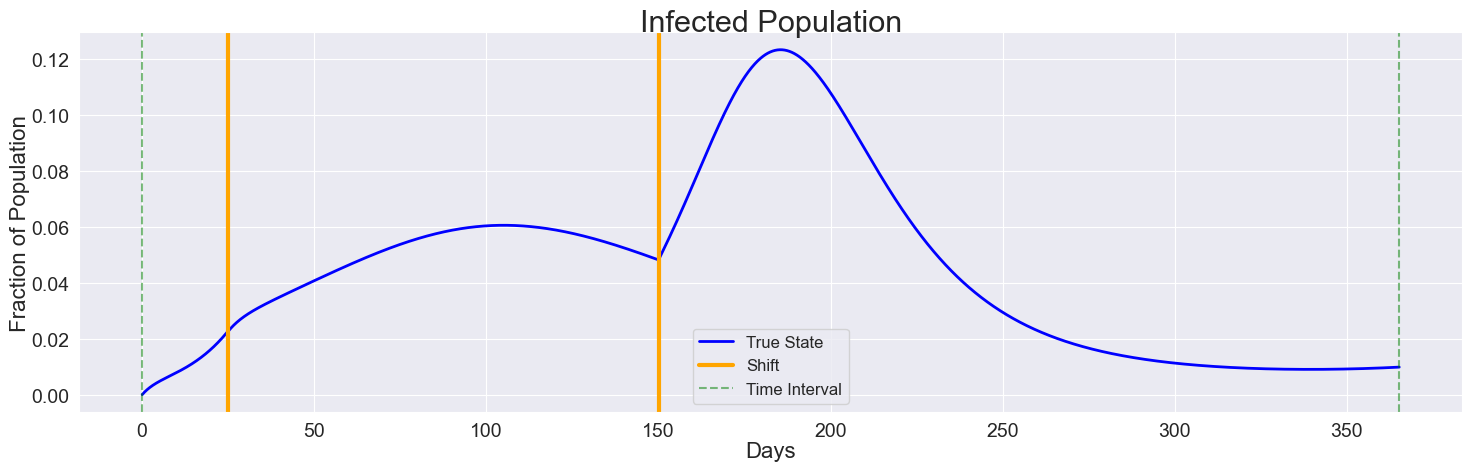

In [2]:
full_sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)
# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(total_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Iterations - Weekly chunks of data.

## Old Functions

In [41]:
from numpy.linalg import LinAlgError
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_df, add_noise, KDEError, set_seed
from pydci import PCAMUDProblem
import pdb
import numpy as np

def online_iterative(
    self,
    time_windows,
    diff=0.5,
    num_samples=100,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.9,
    min_eff_sample_size=0.5,
    weights=None,
    seed=None,
):
    """
    Online solve

    If problem has not been initialized (no self.probs[] array), then the problem
    is initialized with a uniform distribution over the parameter space around the
    true value, with a scale of `diff` controlling the size of the uniform distribution
    around the true value we search for, and hence the problem difficulty.
    Solve inverse problem for `num_its` consuming `time_step` data at each iteration.
    At each iteration, a set of possible sovle parameters will be searched for, using
    varying number of PCA components, data points, and splits. The best solution will
    be determined by the `best_method` argument.

    """
    logger.debug(f'Running online iterative solve over time window {time_windows}')

    if seed is not None:
        logger.info(f'Setting seed to {seed}')
        set_seed(seed)


    if len(time_windows) < 2:
        raise ValueError("time_windows must be a list of at least length 2")
    time_windows.sort()
    if weights is not None and len(weights) != num_samples:
        raise ValueError(f"weights must be None or of length {num_samples}")


    logger.debug(f'Drawing {num_samples} samples from uniform +- {diff} around true value')
    pi_in, samples = self.get_uniform_initial_samples(
        num_samples=num_samples,
        scale=diff)

    weights = [] if weights is None else weights
    best_flag = np.empty((num_samples, 1), dtype=bool)
    t0 = time_windows[0]
    probs = []
    restart = False 
    sample_groups = []                # List of lists of data chunks groups used by common set of samples
    sample_group = []                 # List for current iteration of data chunks used by common set of samples
    skip_intervals = []               # List of intervals where no solution was found  
    for i, t in enumerate(time_windows[1:]):
        sample_group += [i]
        logger.debug(f"Getting measurements over time window {t0} to {t}")
        self.get_data(t - t0, t0=t0)
        measurements = get_df(self.data[-1].dropna(), 'q_lam_obs', self.n_sensors)

        num_tries = 0
        solution_found = False
        prev_samples = samples
        prev_pi_in = pi_in
        while not solution_found and num_tries < 2:
            # Solve -> Saves states in state dictionary
            self.forward_solve(samples, restart=restart)

            prob = PCAMUDProblem(
                self.samples[-1],
                measurements,
                self.measurement_noise,
                pi_in=pi_in,
            )
            prob.set_weights(weights)

            try:
                prob.solve(pca_components=list(range(nc)))
            except ZeroDivisionError as z:
                # Zero division means predictabiltiy assumption violated
                # -> Param shift may have occured as predicted prob
                #    of a sample was set to zero where observed data was non-zero
                e_r_delta = -1.0
                logger.error(f"Failed: Ill-posed problem: {z}. Suspected param shift.")
            else:
                e_r = prob.result["e_r"].values[0]
                e_r_delta = np.abs(e_r - 1.0)
                logger.info(f"Succesfully solved problem - e_r_delta = {e_r_delta}, kl = {prob.divergence_kl()}")

            # If failed to solve problem because we have refined our weights to much
            # On the current set of samples, then resample from previous iterations updated distribution
            # To start with a fresh set of samples and no weights
            # This occurs when
            #   1. Weights vector is too refined, zero-ing out too many samples so we don't have enough variability
            #       in our samples to solve the problem usinG KDEs -> error through by prob.solve() which we catch by setting e_r_delta = 1.0
            #   2. The e_r_delta we get is above our resampling threshold, but not greater than the shift threshold where we may
            #       think that the true params have shifted and a violation of the predictabiltiy assumption is occuring instead
            #       of jus a resolution issue due to weighting of the curent samples.
            # over-ref
            if (e_r_delta > resample_thresh)  and (e_r_delta < shift_thresh):
                if i == 0:
                    # Won't be able to sample from previous if this is the first iteration
                    raise ValueError("Problem is ill-posed and cannot be solved from the first iteration.")
                logger.info(f"|E(r) - 1| = {e_r_delta} : < 0 or > {resample_thresh} -> Resampling from previous pi_up and retrying.")
                samples = probs[-1].sample_dist(num_samples, dist='pi_up')
                pi_in = probs[-1].dists['pi_up']
                logger.info(f"Zeroing out weights and retrying solve.")
                weights = []
                num_tries += 1
                restart = True
            elif e_r_delta > shift_thresh or e_r_delta < 0.0:
                logger.info(f"|E(r) - 1| = {e_r_delta} > {shift_thresh} --> Shift.")
                logger.info(f"Drawing {num_samples} samples from uniform +- {diff} around true value")
                pi_in, samples = self.get_uniform_initial_samples(num_samples=num_samples, scale=diff)
                weights = []
                num_tries += 1
                restart = True
            else:
                logger.info(f"|E(r) - 1| = {e_r_delta} < {resample_thresh} - Keeping solution.")
                logger.info(f"{prob.result}")
                probs.append(prob)

                best_flag = np.empty((num_samples, 1), dtype=bool)
                best_flag[:] = False
                best_flag[prob.mud_arg] = True
                self.samples[-1]['best_flag'] = best_flag

                solution_found = True
                # Determine if new set of weights is too refined -> Calculate effective sample size
                weights.append(prob.state["ratio"].values)
                net_weights = np.prod(np.array(weights).T, axis=1)
                eff_num_samples = len(np.where(net_weights > 1e-10)[0])
                logger.info(f"Effective sample size: {eff_num_samples}")
                if eff_num_samples/num_samples < min_eff_sample_size:
                    logger.info(f"Getting new set of samples ({eff_num_samples} < {min_eff_sample_size}).")
                    samples = prob.sample_dist(num_samples, dist='pi_up')
                    pi_in = prob.dists['pi_up']
                    weights = []
                    restart = True                              # Whether to restart the forward solve simulations or continue from previous final state.
                    sample_groups.append(sample_group)
                    sample_group = []
                else:
                    if num_tries > 0:
                        # Got here after a retry -> Clear sample groups
                        sample_groups.append(sample_group)
                        sample_group = []
                    logger.info(f"Keeping samples.")
                    restart = False
        
        if not solution_found:
            logger.info(f"No good solution found. Skipping to next time window.")
            pi_in = prev_pi_in
            samples = prev_samples 
            restart = False
            skip_intervals.append(i)
            
        
        logger.info(f'Sample groups {sample_group}')
        t0 = t
    
    return sample_groups, probs

def param_density(probs, param_idx=0, idxs=None, figsize=(5,5), lam_true=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot initial at first iteration
    labels = []
    idxs = np.arange(len(probs)) if idxs is None else idxs
    _ = probs[idxs[0]].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs={"color": "black", "linestyle": ":", "fill": True},
                    update_kwargs=None,
                    plot_legend=False,
                    mud_kwargs=None,
                    lam_true=None
    )
    labels += [f'$\pi^{{in}}$']
    if len(idxs) > 2:
        alphas = np.linspace(0.1,0.9,len(idxs))
        for i, j in enumerate(idxs[1:-1]):
            _, l = probs[j].plot_L(ax=ax,
                            param_idx=param_idx,
                            initial_kwargs=None,
                            update_kwargs={"color": "blue", "alpha": alphas[i], "linestyle": "--", "fill": False},
                            plot_legend=False,
                            mud_kwargs=None,
                            lam_true=None
            )
            labels += [f'$\pi^{{up}}_{{{j}}}$']
    # plot update at final iteration
    _, l = probs[idxs[-1]].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs=None,
                    update_kwargs={"color": "blue", "linestyle": "-", "fill": True},
                    plot_legend=False,
                    mud_kwargs={'color': 'blue'},
                    lam_true=None,
    )
    labels += [f'$\pi^{{up}}$', '$\lambda^{mud}$']
    for l in lam_true:
        if len(l) == 2:
            ax.axvline(
                x=l[1][param_idx],
                linewidth=3,
                color="orange",
            )
            labels += [f'$\lambda^{{\dagger}}_{{{l[0]}}}$']
        else:
            ax.axvline(
                x=l[param_idx],
                linewidth=3,
                color="orange",
            )
            labels += [f'$\lambda^{{\dagger}}$']
    labels += l

    ax.legend(labels)

    return ax

def plot_iterations(probs, idxs=None, figsize=(12,12), lam_true=None):

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # idxs = np.arange(1, len(probs)-1, 1 if )
    for i, ax in enumerate(axs.flat):
        param_density(probs, param_idx=i, idxs=idxs, ax=ax, lam_true=lam_true)
    
    return axs
# plot_iterations(probs, idxs=np.arange(0, 10, 2), lam_true=[SEIRS_P2])


def plot_iterations_old(probs, idxs=None, figsize=(9,9), lam_true=None):

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    for i, ax in enumerate(axs.flat):
        # Plot initial at first iteration
        probs[0].plot_L(iteration=0,
                        ax=ax,
                        param_idx=i,
                        initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                        update_kwargs=None,
                        plot_legend=False,
                        mud_kwargs=None,
                        lam_true=None
        )
        # Plot update at final iteration
        probs[-1].plot_L(iteration=-1,
                        ax=ax,
                        param_idx=i,
                        initial_kwargs=None,
                        update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                        plot_legend=False,
                        mud_kwargs={'color': 'blue'},
                        lam_true=lam_true,
        )

# Adaptive Online Iterative

## First 10 weeks - First parameter shift

In [42]:
total_time = 7*10 # 1*365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

best = []
sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sgs, probs = sr.online_iterative(
    np.arange(0, data_chunk_size*n_chunks+ 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.5,
    weights=None,
    seed=2221,
)

2023-07-25 20:41:57.672 | DEBUG    | __main__:online_iterative:33 - Running online iterative solve over time window [ 0  7 14 21 28 35 42 49 56 63 70]
2023-07-25 20:41:57.674 | INFO     | __main__:online_iterative:36 - Setting seed to 2221
2023-07-25 20:41:57.674 | DEBUG    | __main__:online_iterative:47 - Drawing 1000 samples from uniform +- 1.0 around true value
2023-07-25 20:41:57.677 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 0 to 7


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6714.


2023-07-25 20:41:57.827 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.008816307813913626, kl = 1.0520001887147177
2023-07-25 20:41:57.827 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.008816307813913626 < 0.2 - Keeping solution.
2023-07-25 20:41:57.831 | INFO     | __main__:online_iterative:125 -         e_r     kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.008816  1.052   0.154073  ...      942             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:57.832 | INFO     | __main__:online_iterative:138 - Effective sample size: 751
2023-07-25 20:41:57.832 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:41:57.832 | INFO     | __main__:online_iterative:163 - Sample groups [0]
2023-07-25 20:41:57.833 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 7 to 14


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11721


2023-07-25 20:41:57.968 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.004155327913168971, kl = 1.6828413895348828
2023-07-25 20:41:57.969 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.004155327913168971 < 0.2 - Keeping solution.
2023-07-25 20:41:57.978 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.004155  1.682841   0.291503  ...      363             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:57.979 | INFO     | __main__:online_iterative:138 - Effective sample size: 296
2023-07-25 20:41:57.979 | INFO     | __main__:online_iterative:140 - Getting new set of samples (296 < 0.5).
2023-07-25 20:41:57.980 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:41:57.981 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 14 to 21


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7505.


2023-07-25 20:41:58.092 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.03619767596041168, kl = 0.6592132970306472
2023-07-25 20:41:58.092 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.03619767596041168 < 0.2 - Keeping solution.
2023-07-25 20:41:58.096 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.036198  0.659213   0.157399  ...      208             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.096 | INFO     | __main__:online_iterative:138 - Effective sample size: 917
2023-07-25 20:41:58.096 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:41:58.097 | INFO     | __main__:online_iterative:163 - Sample groups [2]
2023-07-25 20:41:58.097 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 21 to 28


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12484


2023-07-25 20:41:58.215 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.037657785830888524, kl = 1.4201205982236176
2023-07-25 20:41:58.216 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.037657785830888524 < 0.2 - Keeping solution.
2023-07-25 20:41:58.220 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.962342  1.420121   0.313227  ...      129             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.220 | INFO     | __main__:online_iterative:138 - Effective sample size: 458
2023-07-25 20:41:58.221 | INFO     | __main__:online_iterative:140 - Getting new set of samples (458 < 0.5).
2023-07-25 20:41:58.223 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:41:58.223 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 28 to 35


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10015


2023-07-25 20:41:58.368 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.035095414467996244, kl = 1.4398006511235362
2023-07-25 20:41:58.368 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.035095414467996244 < 0.2 - Keeping solution.
2023-07-25 20:41:58.372 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.035095  1.439801   0.338721  ...      889             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.373 | INFO     | __main__:online_iterative:138 - Effective sample size: 620
2023-07-25 20:41:58.374 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:41:58.374 | INFO     | __main__:online_iterative:163 - Sample groups [4]
2023-07-25 20:41:58.375 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 35 to 42


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12144


2023-07-25 20:41:58.528 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.9999999992680573, kl = 16.17821486979538
2023-07-25 20:41:58.531 | INFO     | __main__:online_iterative:117 - |E(r) - 1| = 0.9999999992680573 > 0.5 --> Shift.
2023-07-25 20:41:58.533 | INFO     | __main__:online_iterative:118 - Drawing 1000 samples from uniform +- 1.0 around true value


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8927.


2023-07-25 20:41:58.653 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.09644017471957222, kl = 2.3567224862147405
2023-07-25 20:41:58.654 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.09644017471957222 < 0.2 - Keeping solution.
2023-07-25 20:41:58.657 | INFO     | __main__:online_iterative:125 -        e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.90356  2.356722   0.170165  ...      805             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.658 | INFO     | __main__:online_iterative:138 - Effective sample size: 245
2023-07-25 20:41:58.658 | INFO     | __main__:online_iterative:140 - Getting new set of samples (245 < 0.5).
2023-07-25 20:41:58.660 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:41:58.660 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 42 to 49


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9918.


2023-07-25 20:41:58.803 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.002198048936108199, kl = 1.3654189182018652
2023-07-25 20:41:58.803 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.002198048936108199 < 0.2 - Keeping solution.
2023-07-25 20:41:58.807 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.002198  1.365419   0.216349  ...       86             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.807 | INFO     | __main__:online_iterative:138 - Effective sample size: 589
2023-07-25 20:41:58.808 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:41:58.808 | INFO     | __main__:online_iterative:163 - Sample groups [6]
2023-07-25 20:41:58.808 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 49 to 56


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10665


2023-07-25 20:41:58.933 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.1670190309244889, kl = 3.133929579650956
2023-07-25 20:41:58.934 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.1670190309244889 < 0.2 - Keeping solution.
2023-07-25 20:41:58.937 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.832981  3.13393   0.061225  ...      993             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:58.938 | INFO     | __main__:online_iterative:138 - Effective sample size: 99
2023-07-25 20:41:58.938 | INFO     | __main__:online_iterative:140 - Getting new set of samples (99 < 0.5).
2023-07-25 20:41:58.940 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:41:58.943 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 56 to 63


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7986.


2023-07-25 20:41:59.141 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.006667621944016933, kl = 1.2858603714400494
2023-07-25 20:41:59.141 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.006667621944016933 < 0.2 - Keeping solution.
2023-07-25 20:41:59.144 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.006668  1.28586   0.036584  ...      710             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:59.145 | INFO     | __main__:online_iterative:138 - Effective sample size: 767
2023-07-25 20:41:59.145 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:41:59.146 | INFO     | __main__:online_iterative:163 - Sample groups [8]
2023-07-25 20:41:59.146 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 63 to 70


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12747


2023-07-25 20:41:59.268 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.11446903051767154, kl = 1.5410877896266455
2023-07-25 20:41:59.269 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.11446903051767154 < 0.2 - Keeping solution.
2023-07-25 20:41:59.273 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.885531  1.541088   0.111836  ...      401             [0]      None

[1 rows x 9 columns]
2023-07-25 20:41:59.274 | INFO     | __main__:online_iterative:138 - Effective sample size: 450
2023-07-25 20:41:59.274 | INFO     | __main__:online_iterative:140 - Getting new set of samples (450 < 0.5).
2023-07-25 20:41:59.275 | INFO     | __main__:online_iterative:163 - Sample groups []


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

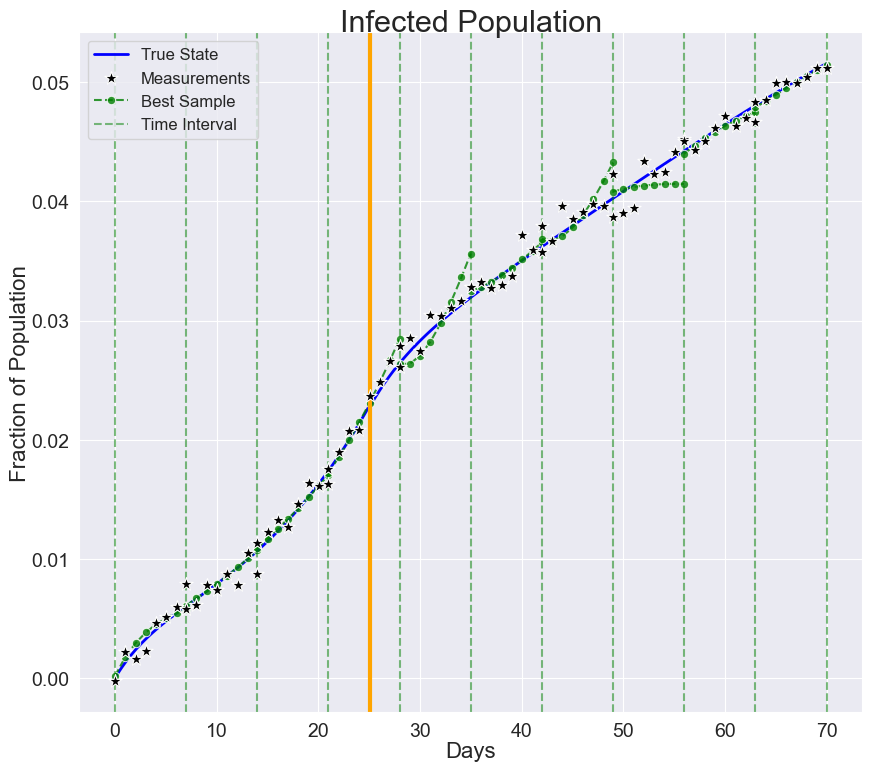

In [45]:
sr.plot_infected(plot_samples=True, n_samples=0)

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

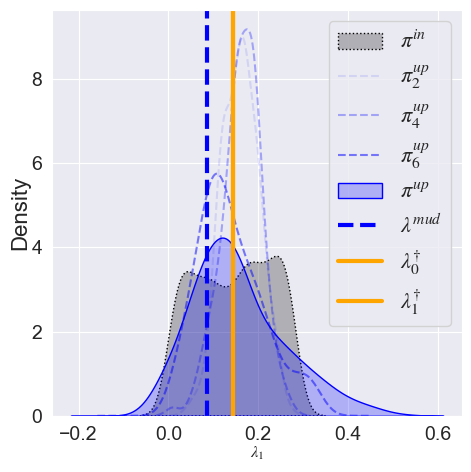

In [48]:
param_density(probs, param_idx=1, idxs=np.arange(0, 10, 2), lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)])

<AxesSubplot: xlabel='$\\lambda_0$', ylabel='Density'>

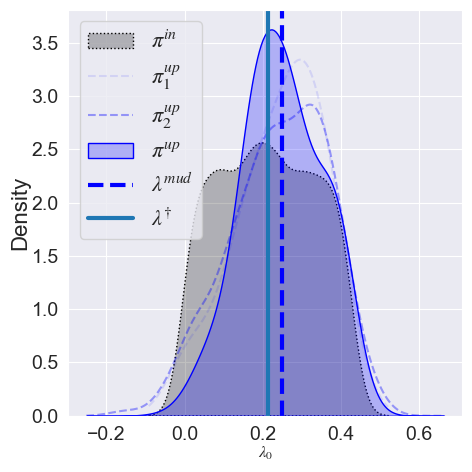

In [53]:
param_density(probs, param_idx=0, idxs=np.arange(0,4), lam_true=[SEIRS_P1])

<AxesSubplot: xlabel='$\\lambda_0$', ylabel='Density'>

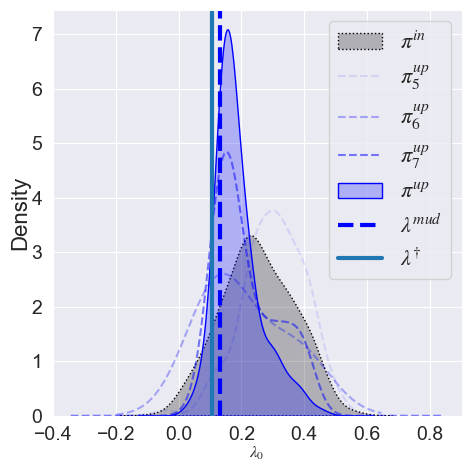

In [54]:
param_density(probs, param_idx=0, idxs=np.arange(4,9), lam_true=[SEIRS_P2])

# Adatpive - Weekly Iterations, Full Year 

In [54]:
total_time = 1*365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

best = []
sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sgs, probs = online_iterative(
    sr,
    np.arange(0, data_chunk_size*n_chunks+ 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
    seed=21,
)

2023-07-25 20:50:51.500 | DEBUG    | __main__:online_iterative:33 - Running online iterative solve over time window [  0   7  14  21  28  35  42  49  56  63  70  77  84  91  98 105 112 119
 126 133 140 147 154 161 168 175 182 189 196 203 210 217 224 231 238 245
 252 259 266 273 280 287 294 301 308 315 322 329 336 343 350 357 364]
2023-07-25 20:50:51.502 | INFO     | __main__:online_iterative:36 - Setting seed to 21
2023-07-25 20:50:51.503 | DEBUG    | __main__:online_iterative:47 - Drawing 1000 samples from uniform +- 1.0 around true value
2023-07-25 20:50:51.506 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 0 to 7


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9738.


2023-07-25 20:50:51.666 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.014997521830420357, kl = 1.1651074840181326
2023-07-25 20:50:51.666 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.014997521830420357 < 0.2 - Keeping solution.
2023-07-25 20:50:51.674 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.014998  1.165107   0.060414  ...      294             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:51.675 | INFO     | __main__:online_iterative:138 - Effective sample size: 760
2023-07-25 20:50:51.675 | INFO     | __main__:online_iterative:140 - Getting new set of samples (760 < 0.8).
2023-07-25 20:50:51.677 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:51.678 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 7 to 14


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9268.


2023-07-25 20:50:51.841 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.039667809464354775, kl = 1.1270075549336065
2023-07-25 20:50:51.842 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.039667809464354775 < 0.2 - Keeping solution.
2023-07-25 20:50:51.850 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.039668  1.127008   0.077474  ...      789             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:51.852 | INFO     | __main__:online_iterative:138 - Effective sample size: 810
2023-07-25 20:50:51.853 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:51.854 | INFO     | __main__:online_iterative:163 - Sample groups [1]
2023-07-25 20:50:51.855 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 14 to 21


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8542.


2023-07-25 20:50:51.998 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.19242975777992433, kl = 1.6441601183921328
2023-07-25 20:50:51.998 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.19242975777992433 < 0.2 - Keeping solution.
2023-07-25 20:50:52.002 | INFO     | __main__:online_iterative:125 -        e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.19243  1.64416   0.182266  ...      647             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.002 | INFO     | __main__:online_iterative:138 - Effective sample size: 266
2023-07-25 20:50:52.002 | INFO     | __main__:online_iterative:140 - Getting new set of samples (266 < 0.8).
2023-07-25 20:50:52.004 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:52.004 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 21 to 28


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10027


2023-07-25 20:50:52.141 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.05047849516618008, kl = 0.9132819795861824
2023-07-25 20:50:52.141 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.05047849516618008 < 0.2 - Keeping solution.
2023-07-25 20:50:52.145 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.050478  0.913282    0.20864  ...      359             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.148 | INFO     | __main__:online_iterative:138 - Effective sample size: 776
2023-07-25 20:50:52.148 | INFO     | __main__:online_iterative:140 - Getting new set of samples (776 < 0.8).
2023-07-25 20:50:52.151 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:52.151 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 28 to 35


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.2s (5629.


2023-07-25 20:50:52.395 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.010647643041491905, kl = 2.062402078346345
2023-07-25 20:50:52.395 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.010647643041491905 < 0.2 - Keeping solution.
2023-07-25 20:50:52.399 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.989352  2.062402   0.189874  ...       44             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.399 | INFO     | __main__:online_iterative:138 - Effective sample size: 544
2023-07-25 20:50:52.400 | INFO     | __main__:online_iterative:140 - Getting new set of samples (544 < 0.8).
2023-07-25 20:50:52.401 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:52.402 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 35 to 42


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8197.


2023-07-25 20:50:52.565 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.03894429302498703, kl = 0.809302039735474
2023-07-25 20:50:52.566 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.03894429302498703 < 0.2 - Keeping solution.
2023-07-25 20:50:52.569 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.038944  0.809302   0.292016  ...       67             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.570 | INFO     | __main__:online_iterative:138 - Effective sample size: 854
2023-07-25 20:50:52.570 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:52.571 | INFO     | __main__:online_iterative:163 - Sample groups [5]
2023-07-25 20:50:52.571 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 42 to 49


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9466.


2023-07-25 20:50:52.701 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.1697734288147792, kl = 7.0620014325533145
2023-07-25 20:50:52.701 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.1697734288147792 < 0.2 - Keeping solution.
2023-07-25 20:50:52.704 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.830227  7.062001   0.167654  ...      901             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.705 | INFO     | __main__:online_iterative:138 - Effective sample size: 43
2023-07-25 20:50:52.706 | INFO     | __main__:online_iterative:140 - Getting new set of samples (43 < 0.8).
2023-07-25 20:50:52.708 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:52.709 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 49 to 56


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8391.


2023-07-25 20:50:52.873 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.015141103474126671, kl = 0.8152741681838063
2023-07-25 20:50:52.874 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.015141103474126671 < 0.2 - Keeping solution.
2023-07-25 20:50:52.878 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.015141  0.815274   0.169342  ...      259             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:52.878 | INFO     | __main__:online_iterative:138 - Effective sample size: 952
2023-07-25 20:50:52.879 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:52.879 | INFO     | __main__:online_iterative:163 - Sample groups [7]
2023-07-25 20:50:52.879 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 56 to 63


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9950.


2023-07-25 20:50:53.000 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.10402016543070824, kl = 0.8267281048107513
2023-07-25 20:50:53.001 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.10402016543070824 < 0.2 - Keeping solution.
2023-07-25 20:50:53.005 | INFO     | __main__:online_iterative:125 -        e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.10402  0.826728   0.169342  ...      259             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.006 | INFO     | __main__:online_iterative:138 - Effective sample size: 697
2023-07-25 20:50:53.007 | INFO     | __main__:online_iterative:140 - Getting new set of samples (697 < 0.8).
2023-07-25 20:50:53.009 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:53.010 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 63 to 70


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7262.


2023-07-25 20:50:53.164 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.007813725013449346, kl = 1.360728164216451
2023-07-25 20:50:53.164 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.007813725013449346 < 0.2 - Keeping solution.
2023-07-25 20:50:53.168 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.992186  1.360728   0.165821  ...       33             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.168 | INFO     | __main__:online_iterative:138 - Effective sample size: 811
2023-07-25 20:50:53.168 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:53.169 | INFO     | __main__:online_iterative:163 - Sample groups [9]
2023-07-25 20:50:53.169 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 70 to 77


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11339


2023-07-25 20:50:53.304 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.002660756073520565, kl = 1.380214924904735
2023-07-25 20:50:53.304 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.002660756073520565 < 0.2 - Keeping solution.
2023-07-25 20:50:53.308 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.002661  1.380215   0.124439  ...      795             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.309 | INFO     | __main__:online_iterative:138 - Effective sample size: 393
2023-07-25 20:50:53.310 | INFO     | __main__:online_iterative:140 - Getting new set of samples (393 < 0.8).
2023-07-25 20:50:53.312 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:53.313 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 77 to 84


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11294


2023-07-25 20:50:53.439 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.01508417900712744, kl = 0.5732295621046759
2023-07-25 20:50:53.439 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.01508417900712744 < 0.2 - Keeping solution.
2023-07-25 20:50:53.442 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.015084  0.57323   0.142231  ...      467             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.444 | INFO     | __main__:online_iterative:138 - Effective sample size: 954
2023-07-25 20:50:53.444 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:53.445 | INFO     | __main__:online_iterative:163 - Sample groups [11]
2023-07-25 20:50:53.446 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 84 to 91


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11233


2023-07-25 20:50:53.568 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.007998439291349468, kl = 0.7274798351615073
2023-07-25 20:50:53.568 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.007998439291349468 < 0.2 - Keeping solution.
2023-07-25 20:50:53.572 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.007998  0.72748   0.112801  ...      550             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.573 | INFO     | __main__:online_iterative:138 - Effective sample size: 753
2023-07-25 20:50:53.573 | INFO     | __main__:online_iterative:140 - Getting new set of samples (753 < 0.8).
2023-07-25 20:50:53.575 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:53.576 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 91 to 98


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8232.


2023-07-25 20:50:53.714 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.029296471734772123, kl = 0.5401661562688392
2023-07-25 20:50:53.714 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.029296471734772123 < 0.2 - Keeping solution.
2023-07-25 20:50:53.718 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.029296  0.540166   0.110411  ...      213             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.718 | INFO     | __main__:online_iterative:138 - Effective sample size: 965
2023-07-25 20:50:53.718 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:53.719 | INFO     | __main__:online_iterative:163 - Sample groups [13]
2023-07-25 20:50:53.719 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 98 to 105


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12682


2023-07-25 20:50:53.833 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.040783771076140174, kl = 1.1415976520307636
2023-07-25 20:50:53.833 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.040783771076140174 < 0.2 - Keeping solution.
2023-07-25 20:50:53.836 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.959216  1.141598   0.100084  ...      956             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.837 | INFO     | __main__:online_iterative:138 - Effective sample size: 813
2023-07-25 20:50:53.837 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:53.838 | INFO     | __main__:online_iterative:163 - Sample groups [13, 14]
2023-07-25 20:50:53.838 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 105 to 112


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (13672


2023-07-25 20:50:53.938 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.031080833361025628, kl = 1.5294277343452225
2023-07-25 20:50:53.938 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.031080833361025628 < 0.2 - Keeping solution.
2023-07-25 20:50:53.942 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.968919  1.529428    0.09133  ...      706             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:53.942 | INFO     | __main__:online_iterative:138 - Effective sample size: 655
2023-07-25 20:50:53.943 | INFO     | __main__:online_iterative:140 - Getting new set of samples (655 < 0.8).
2023-07-25 20:50:53.945 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:53.945 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 112 to 119


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10324


2023-07-25 20:50:54.074 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.004392873084539062, kl = 0.5905212489659029
2023-07-25 20:50:54.074 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.004392873084539062 < 0.2 - Keeping solution.
2023-07-25 20:50:54.077 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.004393  0.590521   0.087023  ...      345             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.078 | INFO     | __main__:online_iterative:138 - Effective sample size: 969
2023-07-25 20:50:54.079 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:54.079 | INFO     | __main__:online_iterative:163 - Sample groups [16]
2023-07-25 20:50:54.079 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 119 to 126


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9508.


2023-07-25 20:50:54.199 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.016405604504203364, kl = 0.5124321910156315
2023-07-25 20:50:54.200 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.016405604504203364 < 0.2 - Keeping solution.
2023-07-25 20:50:54.203 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.016406  0.512432   0.101223  ...      378             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.204 | INFO     | __main__:online_iterative:138 - Effective sample size: 809
2023-07-25 20:50:54.204 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:54.204 | INFO     | __main__:online_iterative:163 - Sample groups [16, 17]
2023-07-25 20:50:54.204 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 126 to 133


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12684


2023-07-25 20:50:54.308 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.10090345130333844, kl = 1.4490838792550274
2023-07-25 20:50:54.308 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.10090345130333844 < 0.2 - Keeping solution.
2023-07-25 20:50:54.312 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.899097  1.449084    0.10102  ...      581             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.313 | INFO     | __main__:online_iterative:138 - Effective sample size: 720
2023-07-25 20:50:54.313 | INFO     | __main__:online_iterative:140 - Getting new set of samples (720 < 0.8).
2023-07-25 20:50:54.315 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:54.316 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 133 to 140


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10041


2023-07-25 20:50:54.473 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.01777266295711355, kl = 0.6656926053514056
2023-07-25 20:50:54.474 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.01777266295711355 < 0.2 - Keeping solution.
2023-07-25 20:50:54.478 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.017773  0.665693   0.099989  ...       82             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.479 | INFO     | __main__:online_iterative:138 - Effective sample size: 960
2023-07-25 20:50:54.479 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:54.480 | INFO     | __main__:online_iterative:163 - Sample groups [19]
2023-07-25 20:50:54.480 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 140 to 147


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11816


2023-07-25 20:50:54.598 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.02597692724436662, kl = 0.23850336146109835
2023-07-25 20:50:54.598 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.02597692724436662 < 0.2 - Keeping solution.
2023-07-25 20:50:54.601 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.025977  0.238503   0.099989  ...       82             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.602 | INFO     | __main__:online_iterative:138 - Effective sample size: 875
2023-07-25 20:50:54.603 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:54.603 | INFO     | __main__:online_iterative:163 - Sample groups [19, 20]
2023-07-25 20:50:54.603 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 147 to 154


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (14185


2023-07-25 20:50:54.709 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.9999999714389329, kl = 57.15701385288021
2023-07-25 20:50:54.709 | INFO     | __main__:online_iterative:117 - |E(r) - 1| = 0.9999999714389329 > 0.5 --> Shift.
2023-07-25 20:50:54.709 | INFO     | __main__:online_iterative:118 - Drawing 1000 samples from uniform +- 1.0 around true value


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7522.


2023-07-25 20:50:54.861 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.005583451042215137, kl = 2.6789703652756645
2023-07-25 20:50:54.862 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.005583451042215137 < 0.2 - Keeping solution.
2023-07-25 20:50:54.866 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.994417  2.67897   0.192375  ...      765             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:54.867 | INFO     | __main__:online_iterative:138 - Effective sample size: 192
2023-07-25 20:50:54.867 | INFO     | __main__:online_iterative:140 - Getting new set of samples (192 < 0.8).
2023-07-25 20:50:54.870 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:54.870 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 154 to 161


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8709.


2023-07-25 20:50:54.981 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.9829622604025784, kl = 9.412269682561929
2023-07-25 20:50:54.982 | INFO     | __main__:online_iterative:117 - |E(r) - 1| = 0.9829622604025784 > 0.5 --> Shift.
2023-07-25 20:50:54.982 | INFO     | __main__:online_iterative:118 - Drawing 1000 samples from uniform +- 1.0 around true value


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10236


2023-07-25 20:50:55.112 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.19747583167017635, kl = 3.873471034574207
2023-07-25 20:50:55.113 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.19747583167017635 < 0.2 - Keeping solution.
2023-07-25 20:50:55.116 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.802524  3.873471   0.071741  ...      342             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.117 | INFO     | __main__:online_iterative:138 - Effective sample size: 96
2023-07-25 20:50:55.117 | INFO     | __main__:online_iterative:140 - Getting new set of samples (96 < 0.8).
2023-07-25 20:50:55.119 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.119 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 161 to 168


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8766.


2023-07-25 20:50:55.264 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.029346856843680103, kl = 1.3868525409429626
2023-07-25 20:50:55.264 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.029346856843680103 < 0.2 - Keeping solution.
2023-07-25 20:50:55.267 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.029347  1.386853   0.290812  ...      814             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.268 | INFO     | __main__:online_iterative:138 - Effective sample size: 591
2023-07-25 20:50:55.268 | INFO     | __main__:online_iterative:140 - Getting new set of samples (591 < 0.8).
2023-07-25 20:50:55.270 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.270 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 168 to 175


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8480.


2023-07-25 20:50:55.424 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.00028809457513334635, kl = 1.3063073012559963
2023-07-25 20:50:55.424 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.00028809457513334635 < 0.2 - Keeping solution.
2023-07-25 20:50:55.427 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.000288  1.306307   0.290617  ...      972             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.428 | INFO     | __main__:online_iterative:138 - Effective sample size: 632
2023-07-25 20:50:55.428 | INFO     | __main__:online_iterative:140 - Getting new set of samples (632 < 0.8).
2023-07-25 20:50:55.430 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.430 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 175 to 182


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7038.


2023-07-25 20:50:55.600 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.07799004578727975, kl = 1.4530829707367183
2023-07-25 20:50:55.619 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.07799004578727975 < 0.2 - Keeping solution.
2023-07-25 20:50:55.637 | INFO     | __main__:online_iterative:125 -        e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.92201  1.453083   0.397895  ...      345             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.640 | INFO     | __main__:online_iterative:138 - Effective sample size: 595
2023-07-25 20:50:55.641 | INFO     | __main__:online_iterative:140 - Getting new set of samples (595 < 0.8).
2023-07-25 20:50:55.644 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.645 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 182 to 189


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4158.


2023-07-25 20:50:55.810 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.019122976307194728, kl = 1.1954413125295411
2023-07-25 20:50:55.810 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.019122976307194728 < 0.2 - Keeping solution.
2023-07-25 20:50:55.815 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.019123  1.195441    0.36355  ...      703             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.816 | INFO     | __main__:online_iterative:138 - Effective sample size: 668
2023-07-25 20:50:55.816 | INFO     | __main__:online_iterative:140 - Getting new set of samples (668 < 0.8).
2023-07-25 20:50:55.819 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.819 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 189 to 196


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8583.


2023-07-25 20:50:55.962 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.04696279742919507, kl = 0.9611044255650493
2023-07-25 20:50:55.963 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.04696279742919507 < 0.2 - Keeping solution.
2023-07-25 20:50:55.966 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.046963  0.961104   0.311333  ...      668             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:55.967 | INFO     | __main__:online_iterative:138 - Effective sample size: 746
2023-07-25 20:50:55.967 | INFO     | __main__:online_iterative:140 - Getting new set of samples (746 < 0.8).
2023-07-25 20:50:55.971 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:55.971 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 196 to 203


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7758.


2023-07-25 20:50:56.117 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.06003834183080059, kl = 0.9756644517746608
2023-07-25 20:50:56.118 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.06003834183080059 < 0.2 - Keeping solution.
2023-07-25 20:50:56.121 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.060038  0.975664   0.380987  ...      774             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.121 | INFO     | __main__:online_iterative:138 - Effective sample size: 762
2023-07-25 20:50:56.122 | INFO     | __main__:online_iterative:140 - Getting new set of samples (762 < 0.8).
2023-07-25 20:50:56.123 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:56.123 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 203 to 210


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (7064.


2023-07-25 20:50:56.267 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.06386724532843657, kl = 0.660195831215323
2023-07-25 20:50:56.267 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.06386724532843657 < 0.2 - Keeping solution.
2023-07-25 20:50:56.271 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.063867  0.660196   0.409141  ...      156             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.273 | INFO     | __main__:online_iterative:138 - Effective sample size: 889
2023-07-25 20:50:56.274 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:56.274 | INFO     | __main__:online_iterative:163 - Sample groups [29]
2023-07-25 20:50:56.274 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 210 to 217


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8842.


2023-07-25 20:50:56.408 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.14264688078274168, kl = 2.261911643519976
2023-07-25 20:50:56.409 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.14264688078274168 < 0.2 - Keeping solution.
2023-07-25 20:50:56.412 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.142647  2.261912   0.284708  ...      665             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.413 | INFO     | __main__:online_iterative:138 - Effective sample size: 234
2023-07-25 20:50:56.413 | INFO     | __main__:online_iterative:140 - Getting new set of samples (234 < 0.8).
2023-07-25 20:50:56.414 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:56.415 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 217 to 224


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (9168.


2023-07-25 20:50:56.558 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.024689720242724977, kl = 0.4941335292468687
2023-07-25 20:50:56.558 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.024689720242724977 < 0.2 - Keeping solution.
2023-07-25 20:50:56.562 | INFO     | __main__:online_iterative:125 -        e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.02469  0.494134   0.260279  ...      143             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.563 | INFO     | __main__:online_iterative:138 - Effective sample size: 973
2023-07-25 20:50:56.563 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:56.564 | INFO     | __main__:online_iterative:163 - Sample groups [31]
2023-07-25 20:50:56.564 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 224 to 231


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11355


2023-07-25 20:50:56.694 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.024858325230072698, kl = 0.3669103676500559
2023-07-25 20:50:56.694 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.024858325230072698 < 0.2 - Keeping solution.
2023-07-25 20:50:56.699 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.024858  0.36691   0.304485  ...      233             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.700 | INFO     | __main__:online_iterative:138 - Effective sample size: 886
2023-07-25 20:50:56.700 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:56.700 | INFO     | __main__:online_iterative:163 - Sample groups [31, 32]
2023-07-25 20:50:56.701 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 231 to 238


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12897


2023-07-25 20:50:56.816 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.017861445810057663, kl = 1.2907725786952837
2023-07-25 20:50:56.816 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.017861445810057663 < 0.2 - Keeping solution.
2023-07-25 20:50:56.819 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.017861  1.290773   0.285386  ...      219             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.820 | INFO     | __main__:online_iterative:138 - Effective sample size: 557
2023-07-25 20:50:56.820 | INFO     | __main__:online_iterative:140 - Getting new set of samples (557 < 0.8).
2023-07-25 20:50:56.822 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:56.822 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 238 to 245


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10337


2023-07-25 20:50:56.963 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.02054846477511374, kl = 0.4113763038706614
2023-07-25 20:50:56.963 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.02054846477511374 < 0.2 - Keeping solution.
2023-07-25 20:50:56.967 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.020548  0.411376   0.218587  ...      762             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:56.968 | INFO     | __main__:online_iterative:138 - Effective sample size: 991
2023-07-25 20:50:56.969 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:56.969 | INFO     | __main__:online_iterative:163 - Sample groups [34]
2023-07-25 20:50:56.970 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 245 to 252


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (11427


2023-07-25 20:50:57.084 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.04247096760283331, kl = 0.758997916238594
2023-07-25 20:50:57.084 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.04247096760283331 < 0.2 - Keeping solution.
2023-07-25 20:50:57.088 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.957529  0.758998   0.325307  ...      335             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.089 | INFO     | __main__:online_iterative:138 - Effective sample size: 954
2023-07-25 20:50:57.089 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.090 | INFO     | __main__:online_iterative:163 - Sample groups [34, 35]
2023-07-25 20:50:57.090 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 252 to 259


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12687


2023-07-25 20:50:57.205 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.009673222937268022, kl = 0.35569120441966506
2023-07-25 20:50:57.205 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.009673222937268022 < 0.2 - Keeping solution.
2023-07-25 20:50:57.209 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.009673  0.355691   0.232081  ...      138             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.209 | INFO     | __main__:online_iterative:138 - Effective sample size: 902
2023-07-25 20:50:57.210 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.210 | INFO     | __main__:online_iterative:163 - Sample groups [34, 35, 36]
2023-07-25 20:50:57.210 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 259 to 266


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (13893


2023-07-25 20:50:57.332 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.05494665801035259, kl = 0.5856130102873491
2023-07-25 20:50:57.333 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.05494665801035259 < 0.2 - Keeping solution.
2023-07-25 20:50:57.336 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.054947  0.585613   0.276695  ...      961             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.337 | INFO     | __main__:online_iterative:138 - Effective sample size: 786
2023-07-25 20:50:57.337 | INFO     | __main__:online_iterative:140 - Getting new set of samples (786 < 0.8).
2023-07-25 20:50:57.338 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:57.339 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 266 to 273


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8666.


2023-07-25 20:50:57.472 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.02813492289720476, kl = 0.3141045484177516
2023-07-25 20:50:57.472 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.02813492289720476 < 0.2 - Keeping solution.
2023-07-25 20:50:57.476 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.028135  0.314105    0.20373  ...      377             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.477 | INFO     | __main__:online_iterative:138 - Effective sample size: 995
2023-07-25 20:50:57.478 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.478 | INFO     | __main__:online_iterative:163 - Sample groups [38]
2023-07-25 20:50:57.479 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 273 to 280


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10810


2023-07-25 20:50:57.598 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.011461190384291609, kl = 0.16013617418851864
2023-07-25 20:50:57.598 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.011461190384291609 < 0.2 - Keeping solution.
2023-07-25 20:50:57.602 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.011461  0.160136   0.195719  ...      790             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.606 | INFO     | __main__:online_iterative:138 - Effective sample size: 971
2023-07-25 20:50:57.606 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.607 | INFO     | __main__:online_iterative:163 - Sample groups [38, 39]
2023-07-25 20:50:57.607 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 280 to 287


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (14677


2023-07-25 20:50:57.737 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.0333954716632866, kl = 0.5123692069097396
2023-07-25 20:50:57.737 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.0333954716632866 < 0.2 - Keeping solution.
2023-07-25 20:50:57.741 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.966605  0.512369   0.273774  ...      511             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.742 | INFO     | __main__:online_iterative:138 - Effective sample size: 953
2023-07-25 20:50:57.742 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.743 | INFO     | __main__:online_iterative:163 - Sample groups [38, 39, 40]
2023-07-25 20:50:57.743 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 287 to 294


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12979


2023-07-25 20:50:57.847 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.04978006722914474, kl = 0.6330967932221616
2023-07-25 20:50:57.848 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.04978006722914474 < 0.2 - Keeping solution.
2023-07-25 20:50:57.851 | INFO     | __main__:online_iterative:125 -        e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.95022  0.633097    0.23662  ...      222             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.852 | INFO     | __main__:online_iterative:138 - Effective sample size: 904
2023-07-25 20:50:57.852 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.852 | INFO     | __main__:online_iterative:163 - Sample groups [38, 39, 40, 41]
2023-07-25 20:50:57.853 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 294 to 301


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (15604


2023-07-25 20:50:57.940 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.07668383077972929, kl = 1.0768492740723339
2023-07-25 20:50:57.940 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.07668383077972929 < 0.2 - Keeping solution.
2023-07-25 20:50:57.944 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.923316  1.076849   0.223807  ...      478             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:57.947 | INFO     | __main__:online_iterative:138 - Effective sample size: 847
2023-07-25 20:50:57.948 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:57.953 | INFO     | __main__:online_iterative:163 - Sample groups [38, 39, 40, 41, 42]
2023-07-25 20:50:57.955 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 301 to 308


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (17193


2023-07-25 20:50:58.096 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.22464080896681837, kl = 2.007398967215386
2023-07-25 20:50:58.097 | INFO     | __main__:online_iterative:109 - |E(r) - 1| = 0.22464080896681837 : < 0 or > 0.2 -> Resampling from previous pi_up and retrying.
2023-07-25 20:50:58.099 | INFO     | __main__:online_iterative:112 - Zeroing out weights and retrying solve.


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (10307


2023-07-25 20:50:58.232 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.01833485039498961, kl = 0.5221033591885542
2023-07-25 20:50:58.233 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.01833485039498961 < 0.2 - Keeping solution.
2023-07-25 20:50:58.237 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.018335  0.522103   0.239732  ...      374             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.238 | INFO     | __main__:online_iterative:138 - Effective sample size: 987
2023-07-25 20:50:58.238 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.239 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:58.239 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 308 to 315


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8771.


2023-07-25 20:50:58.358 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.00475723104665704, kl = 0.2424613156249568
2023-07-25 20:50:58.358 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.00475723104665704 < 0.2 - Keeping solution.
2023-07-25 20:50:58.362 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.004757  0.242461   0.217835  ...      642             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.363 | INFO     | __main__:online_iterative:138 - Effective sample size: 957
2023-07-25 20:50:58.363 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.364 | INFO     | __main__:online_iterative:163 - Sample groups [44]
2023-07-25 20:50:58.364 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 315 to 322


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6737.


2023-07-25 20:50:58.482 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.0228576119971875, kl = 0.09139383300083481
2023-07-25 20:50:58.483 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.0228576119971875 < 0.2 - Keeping solution.
2023-07-25 20:50:58.486 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.022858  0.091394   0.217835  ...      642             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.486 | INFO     | __main__:online_iterative:138 - Effective sample size: 920
2023-07-25 20:50:58.486 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.487 | INFO     | __main__:online_iterative:163 - Sample groups [44, 45]
2023-07-25 20:50:58.487 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 322 to 329


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (17465


2023-07-25 20:50:58.580 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.008036796717209915, kl = 0.3858909312662433
2023-07-25 20:50:58.580 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.008036796717209915 < 0.2 - Keeping solution.
2023-07-25 20:50:58.583 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.991963  0.385891   0.217835  ...      642             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.583 | INFO     | __main__:online_iterative:138 - Effective sample size: 868
2023-07-25 20:50:58.584 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.584 | INFO     | __main__:online_iterative:163 - Sample groups [44, 45, 46]
2023-07-25 20:50:58.584 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 329 to 336


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (16408


2023-07-25 20:50:58.682 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.026098207916722016, kl = 0.08095926396475579
2023-07-25 20:50:58.682 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.026098207916722016 < 0.2 - Keeping solution.
2023-07-25 20:50:58.686 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.026098  0.080959   0.217835  ...      642             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.686 | INFO     | __main__:online_iterative:138 - Effective sample size: 811
2023-07-25 20:50:58.687 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.687 | INFO     | __main__:online_iterative:163 - Sample groups [44, 45, 46, 47]
2023-07-25 20:50:58.688 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 336 to 343


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (12218


2023-07-25 20:50:58.824 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.017864531065598155, kl = 0.4515247214832512
2023-07-25 20:50:58.825 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.017864531065598155 < 0.2 - Keeping solution.
2023-07-25 20:50:58.829 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.982135  0.451525   0.217835  ...      642             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.830 | INFO     | __main__:online_iterative:138 - Effective sample size: 754
2023-07-25 20:50:58.830 | INFO     | __main__:online_iterative:140 - Getting new set of samples (754 < 0.8).
2023-07-25 20:50:58.833 | INFO     | __main__:online_iterative:163 - Sample groups []
2023-07-25 20:50:58.834 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 343 to 350


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6223.


2023-07-25 20:50:58.958 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.02327178302087063, kl = 0.41945127773292984
2023-07-25 20:50:58.958 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.02327178302087063 < 0.2 - Keeping solution.
2023-07-25 20:50:58.962 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  1.023272  0.419451   0.244196  ...      669             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:58.963 | INFO     | __main__:online_iterative:138 - Effective sample size: 990
2023-07-25 20:50:58.963 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:58.963 | INFO     | __main__:online_iterative:163 - Sample groups [49]
2023-07-25 20:50:58.964 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 350 to 357


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (14030


2023-07-25 20:50:59.053 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.007308217756299862, kl = 0.4417561171787058
2023-07-25 20:50:59.054 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.007308217756299862 < 0.2 - Keeping solution.
2023-07-25 20:50:59.057 | INFO     | __main__:online_iterative:125 -         e_r        kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.992692  0.441756   0.265151  ...      290             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:59.058 | INFO     | __main__:online_iterative:138 - Effective sample size: 952
2023-07-25 20:50:59.058 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:59.059 | INFO     | __main__:online_iterative:163 - Sample groups [49, 50]
2023-07-25 20:50:59.059 | DEBUG    | __main__:online_iterative:62 - Getting measurements over time window 357 to 364


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (8946.


2023-07-25 20:50:59.191 | INFO     | __main__:online_iterative:93 - Succesfully solved problem - e_r_delta = 0.0489220777305156, kl = 0.6090699616640123
2023-07-25 20:50:59.192 | INFO     | __main__:online_iterative:124 - |E(r) - 1| = 0.0489220777305156 < 0.2 - Keeping solution.
2023-07-25 20:50:59.195 | INFO     | __main__:online_iterative:125 -         e_r       kl  lam_MUD_0  ...  MUD_idx  pca_components  pca_mask
0  0.951078  0.60907   0.244196  ...      669             [0]      None

[1 rows x 9 columns]
2023-07-25 20:50:59.195 | INFO     | __main__:online_iterative:138 - Effective sample size: 909
2023-07-25 20:50:59.195 | INFO     | __main__:online_iterative:152 - Keeping samples.
2023-07-25 20:50:59.196 | INFO     | __main__:online_iterative:163 - Sample groups [49, 50, 51]


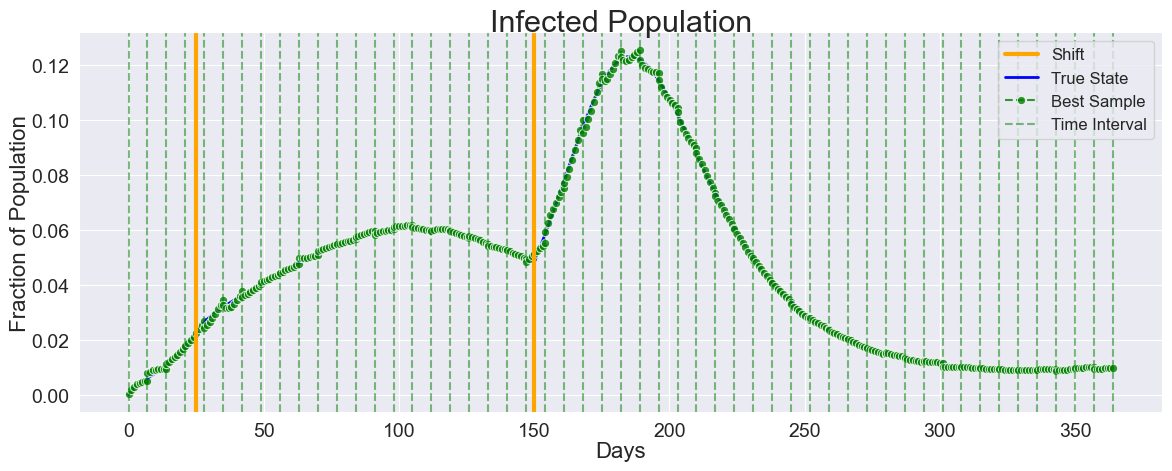

In [55]:
ax = sr.plot_infected(plot_measurements=False, plot_samples=True, n_samples=0, figsize=(12,5))

In [59]:
first_shift_end = 100

(-0.007089759073479672, 0.08)

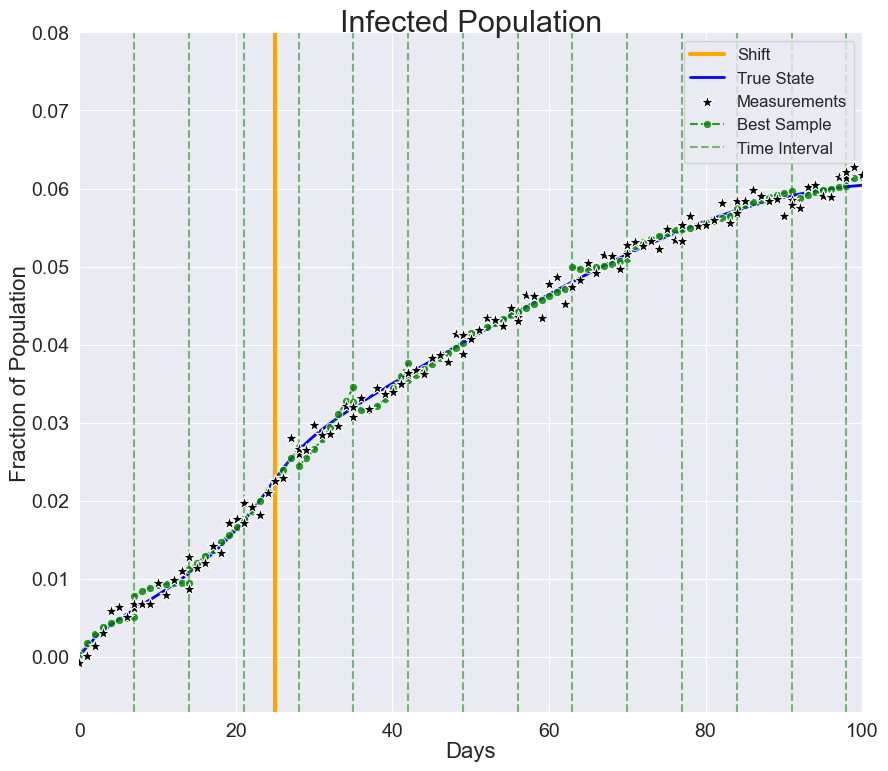

In [60]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([0,first_shift_end])
ax.set_ylim([ax.get_ylim()[0],0.08])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

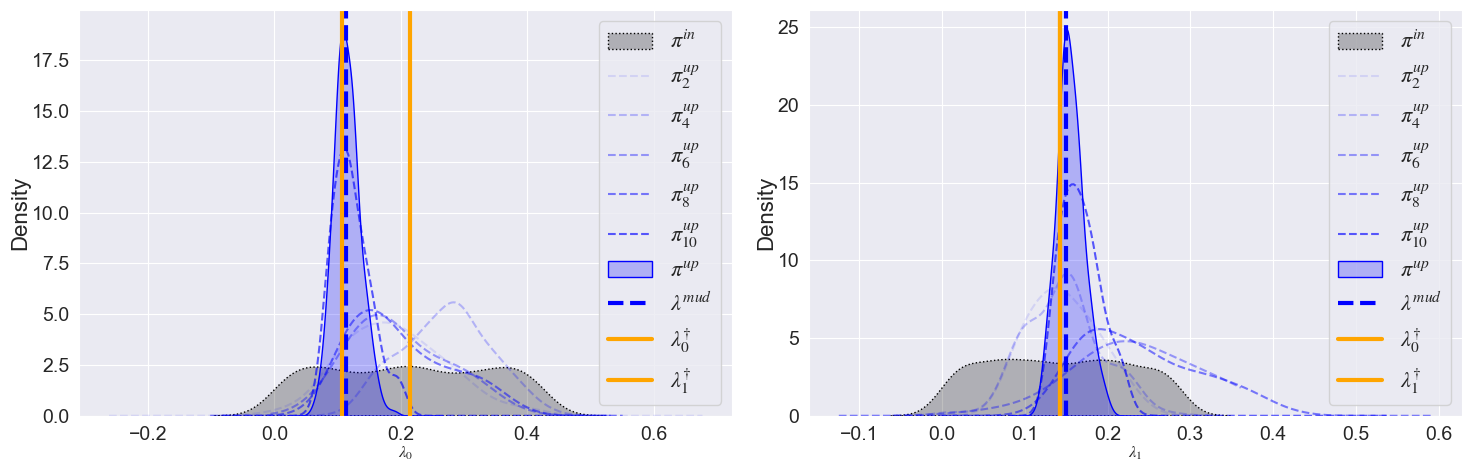

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
param_density(probs, param_idx=0, idxs=np.arange(0, int(first_shift_end/7), 2), lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)], ax=axs[0])
param_density(probs, param_idx=1, idxs=np.arange(0, int(first_shift_end/7), 2), lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)], ax=axs[1])

(120.0, 190.0)

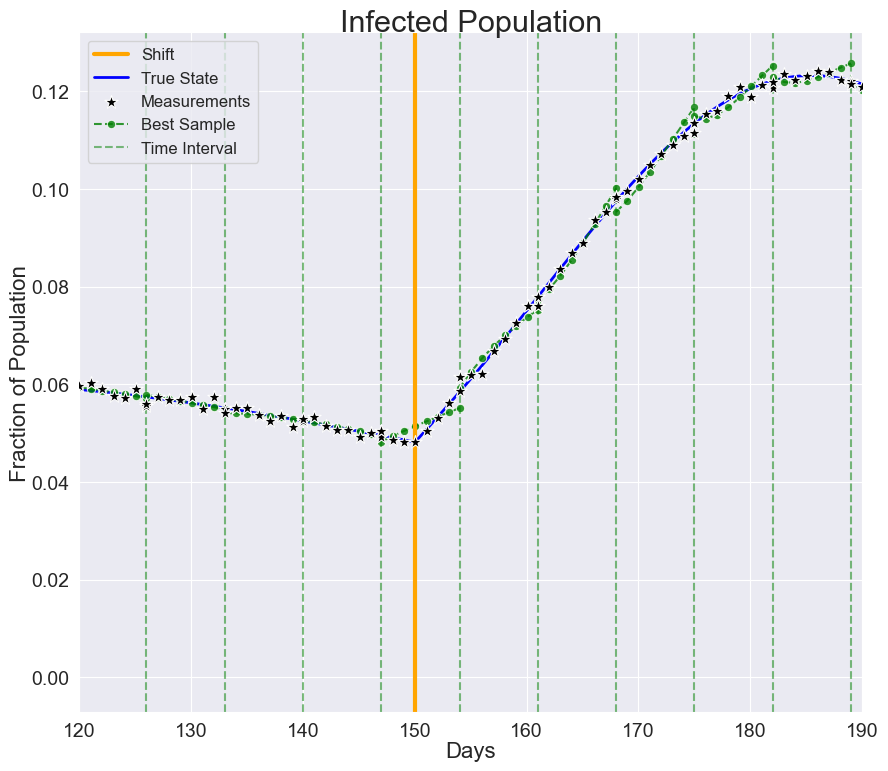

In [62]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([120,190])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

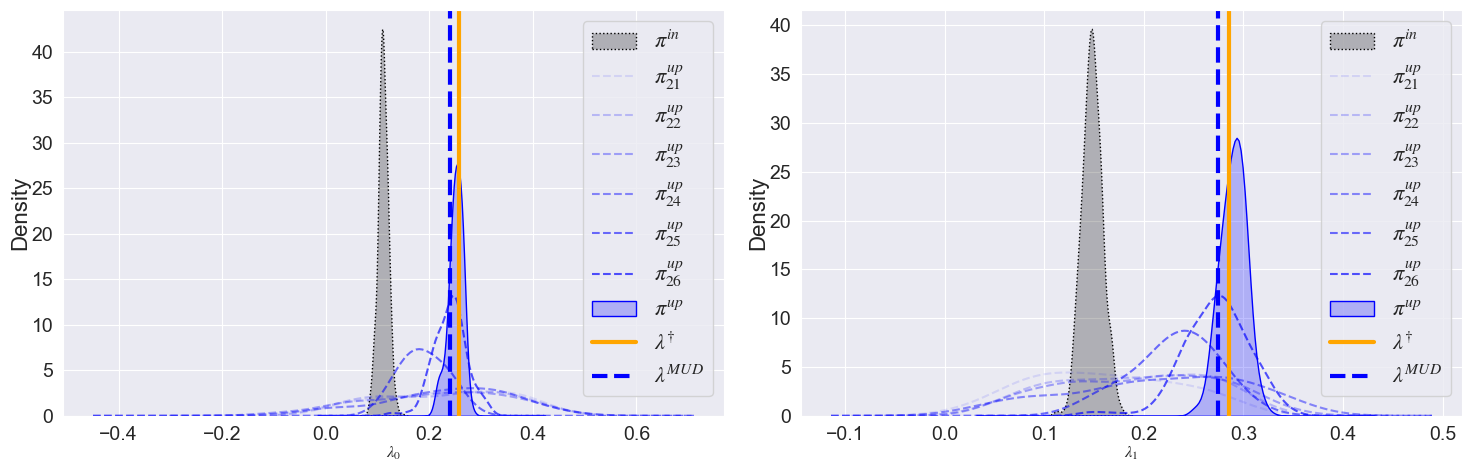

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
param_density(probs, param_idx=0, idxs=np.arange(int(140/7), int(200/7), 1), lam_true=[SEIRS_P3], ax=axs[0])
param_density(probs, param_idx=1, idxs=np.arange(int(140/7), int(200/7), 1), lam_true=[SEIRS_P3], ax=axs[1])


# Online Iteartive Breakdown

## Frist Iteration

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (5776.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

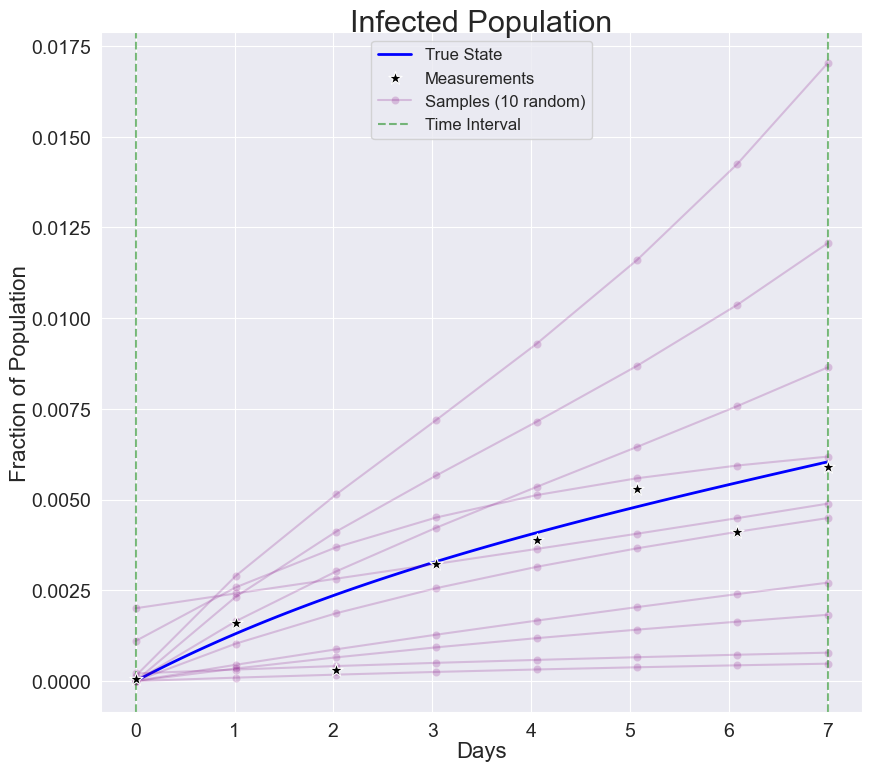

In [4]:
# enable_log(level='DEBUG')
disable_log()

pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.get_data(7)
sr.forward_solve(samples)
sr.plot_infected()

In [133]:
import pandas as pd
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=3)
pd.DataFrame(search_combs)

search_combs = [{
   'exp_thresh': 0.2,
   'pca_components': [[0]],
   'pca_splits': 2
}]

In [6]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=3, all_data=True)
search_combs

[{'exp_thresh': 10000000000.0,
  'pca_components': [[0]],
  'pca_mask': range(0, 8),
  'pca_splits': 1},
 {'exp_thresh': 10000000000.0,
  'pca_components': [[0]],
  'pca_mask': range(0, 8),
  'pca_splits': 2}]

In [134]:
disable_log()
res_1 = sr.solve_search(
    search_combs,
    exp_thresh=0.2,
    best_method="max_kl",
    pi_in=pi_in)
search_res_1 = get_l2_errs(res_1['search_results'], SEIRS_P1)
best.append(res_1['best'])

Solving for different combinations |████████████████████████████████████████| 1/


e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.980294  1.036283   0.165348   0.114875   0.083488   0.001168      523   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(4, 8)  1      0       0.019706           True   

   closest  max_kl  min_kl   l2_err   rel_err  
0     True    True    True  0.05767  0.215771

In [121]:
best[0].it_results

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.062468  1.294052   0.099890   0.193539   0.117335   0.001367      380   
0  0.947284  3.347988   0.354853   0.085463   0.068537   0.003161      584   

  pca_components       pca_mask  i  
0            [0]   range(0, 11)  0  
0            [0]  range(11, 21)  1

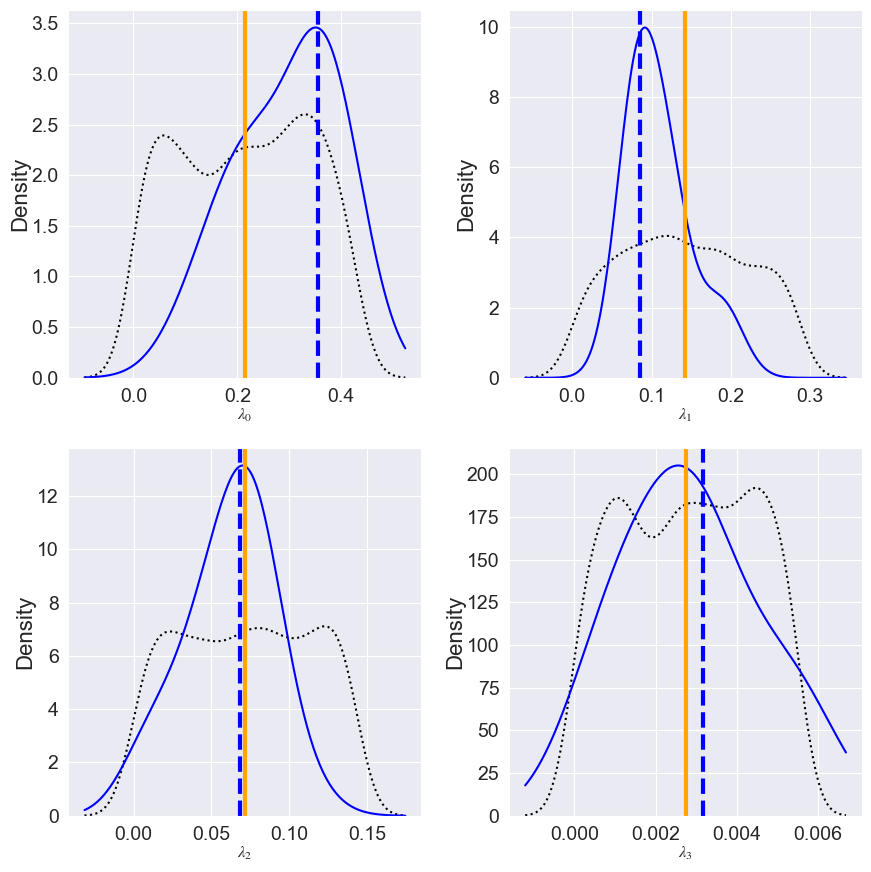

In [122]:
plot_iterations(best, lam_true=[SEIRS_P1])

## Second Iteration

In [55]:
samples = best[0].sample_dist(num_samples=n_samples)

Solving model sample set: |                    | ▁▃▅ 1/1000 [0%] in 0s (~0s, 208

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4617.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

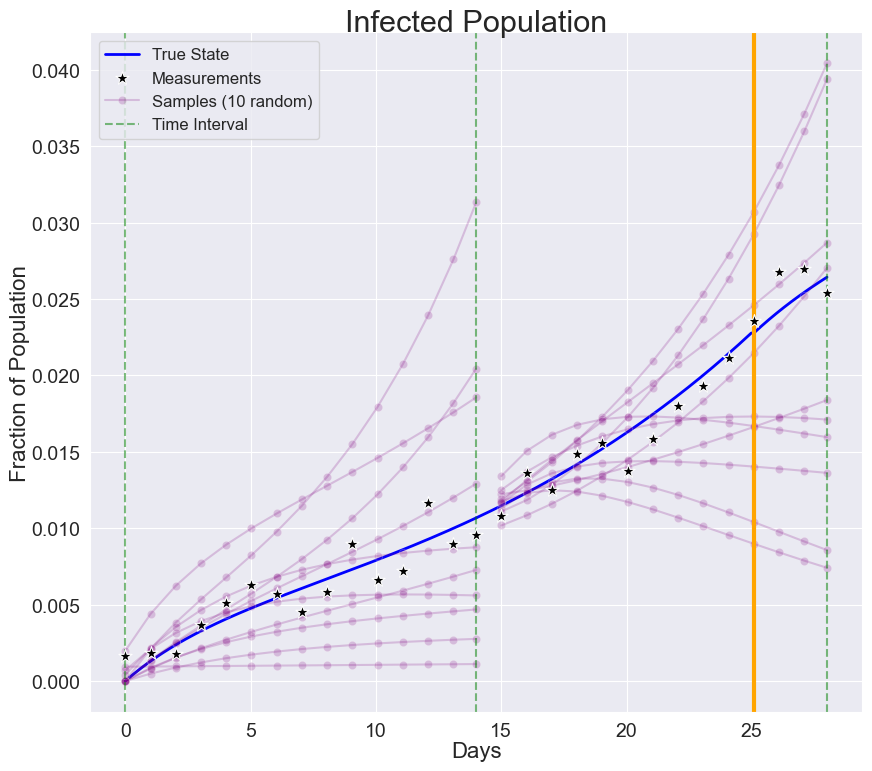

In [56]:
disable_log()

sr.get_data(data_chunk_size)
sr.forward_solve(samples)
sr.plot_infected()

In [58]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=7)
pd.DataFrame(search_combs)

exp_thresh pca_components  \
0  1.000000e+10          [[0]]   
1  1.000000e+10          [[0]]   
2  1.000000e+10          [[0]]   

                                         pca_mask  pca_splits  
0                           (0, 1, 2, 3, 4, 5, 6)           1  
1  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)           1  
2  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)           2

In [ ]:
disable_log()
res_2 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_2 = get_l2_errs(res_2['search_results'], SEIRS_P1)
best.append(res_2['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_2

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.058830  2.283828   0.229384   0.127783   0.064973   0.002731      648   
0  0.964375  3.218909   0.134777   0.116725   0.029469   0.002514      138   
0  0.082564  3.013896   0.327144   0.165581   0.131574   0.001948      272   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.058830           True   
0         [0, 1]  range(0, 7)  0      1       0.035625           True   
0      [0, 1, 2]  range(0, 7)  0      2       0.917436          False   

   closest  max_kl  min_kl    l2_err   rel_err  
0    False   False    True  0.022290  0.083398  
0     True    True   False  0.093622  0.350283  
0    False   False   False  0.129891  0.485980

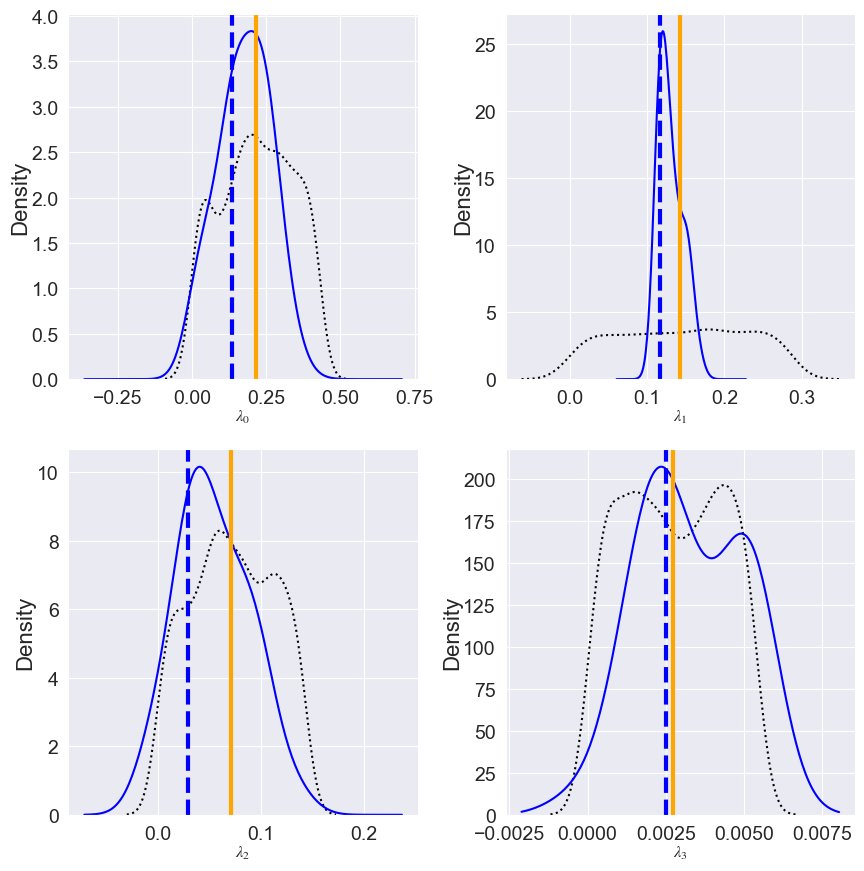

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P1])

## Third Iteration

In [ ]:
samples = best[1].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6131.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

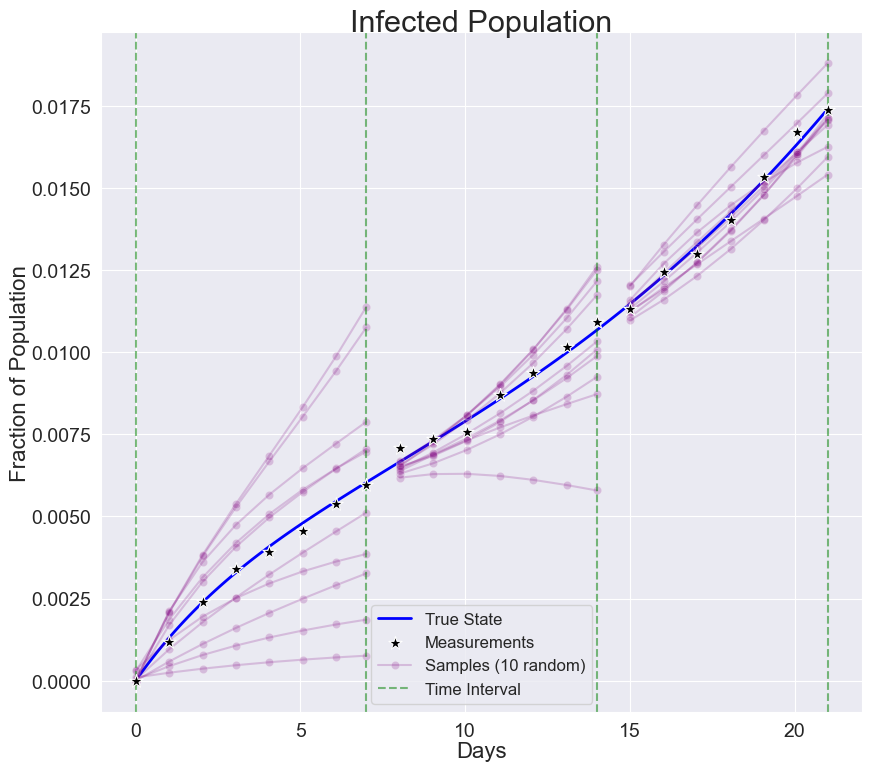

In [ ]:
sr.get_data(3*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_3 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_3 = get_l2_errs(res_3['search_results'], SEIRS_P1)
best.append(res_3['best'])
search_res_3

Solving for different combinations |████████████████████████████████████████| 3/


e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.056461  1.048761   0.205307   0.136466   0.065253   0.006360       19   
0  1.130793  1.682465   0.222689   0.125593   0.059344   0.002354      727   
0  0.973798  1.747766   0.133617   0.117060   0.025240   0.002020      752   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.056461           True   
0         [0, 1]  range(0, 7)  0      1       0.130793           True   
0      [0, 1, 2]  range(0, 7)  0      2       0.026202           True   

   closest  max_kl  min_kl    l2_err   rel_err  
0    False   False    True  0.013142  0.049169  
0    False   False   False  0.022690  0.084895  
0     True    True   False  0.096472  0.360946

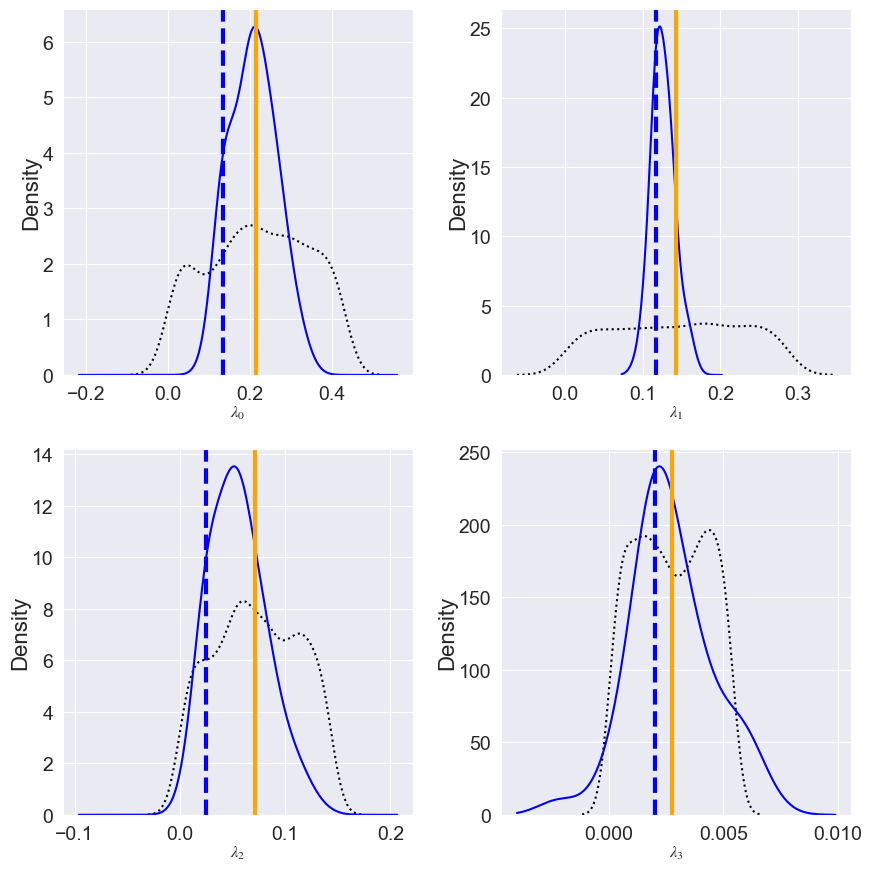

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P1])

## Fourth Iteration -> Shift

In [ ]:
samples = best[2].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (5899.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

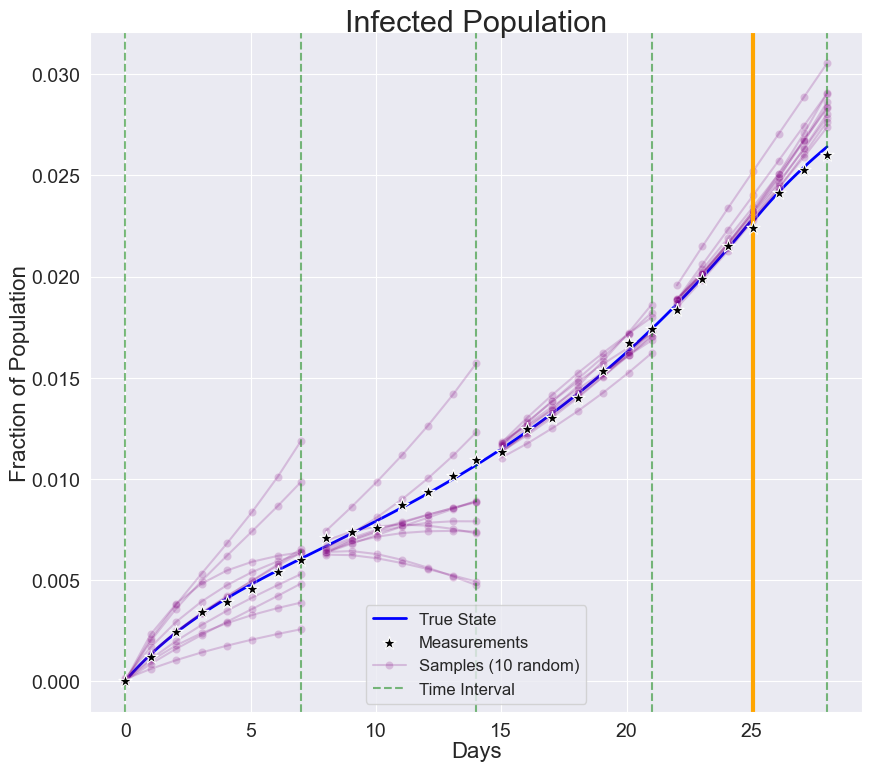

In [ ]:
sr.get_data(4*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_4 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_4 = get_l2_errs(res_4['search_results'], SEIRS_P1)
best.append(res_4['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_4

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.944136  3.011576   0.191607   0.110373   0.045725   0.006332      486   
0  0.022512  8.512823   0.256762   0.164529   0.111781   0.004121      369   
0  0.000004  7.216180   0.235575   0.157362   0.094580   0.007446      787   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.055864           True   
0         [0, 1]  range(0, 7)  0      1       0.977488          False   
0      [0, 1, 2]  range(0, 7)  0      2       0.999996          False   

   closest  max_kl  min_kl    l2_err   rel_err  
0     True    True    True  0.047362  0.177202  
0    False   False   False  0.062483  0.233779  
0    False   False   False  0.034954  0.130777

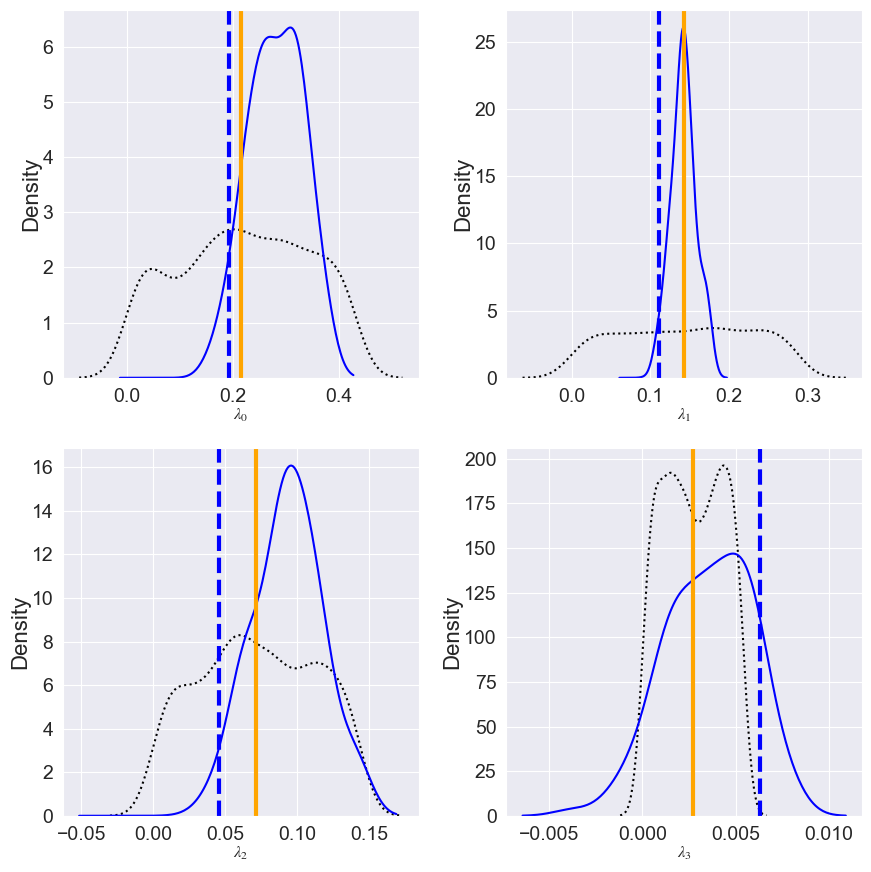

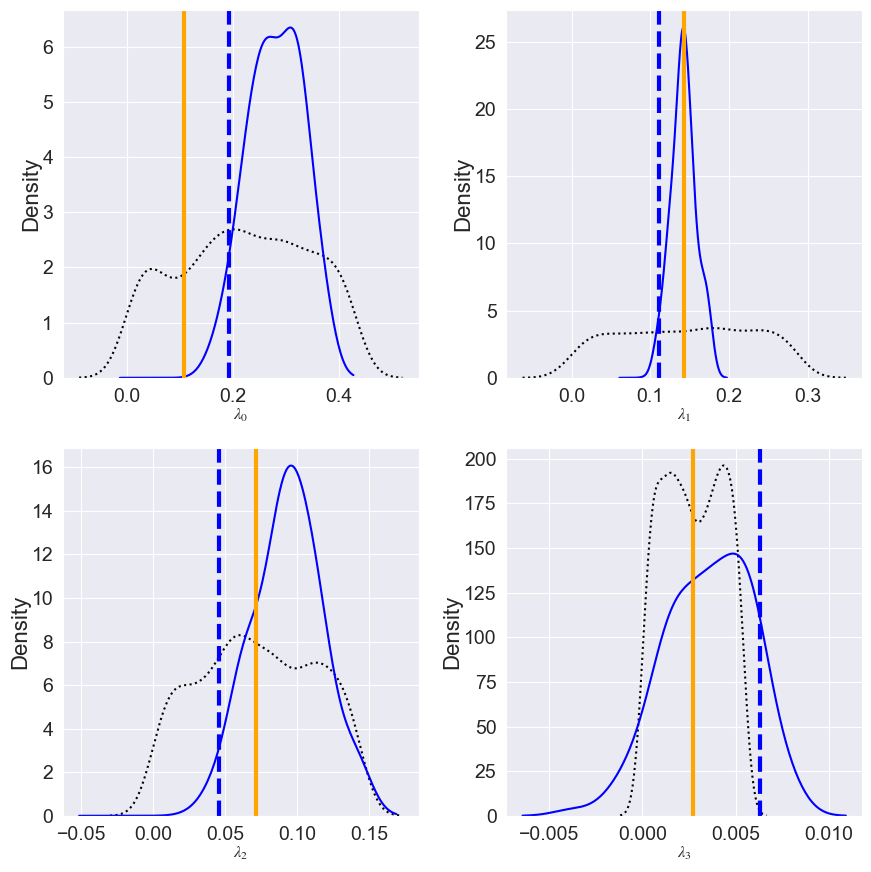

In [ ]:
# TODO: Improve thie plot to show both shifts on same param plots
plot_iterations(best, lam_true=[SEIRS_P1])
plot_iterations(best, lam_true=[SEIRS_P2])

## Fifth Iteration

In [ ]:
samples = best[3].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4271.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

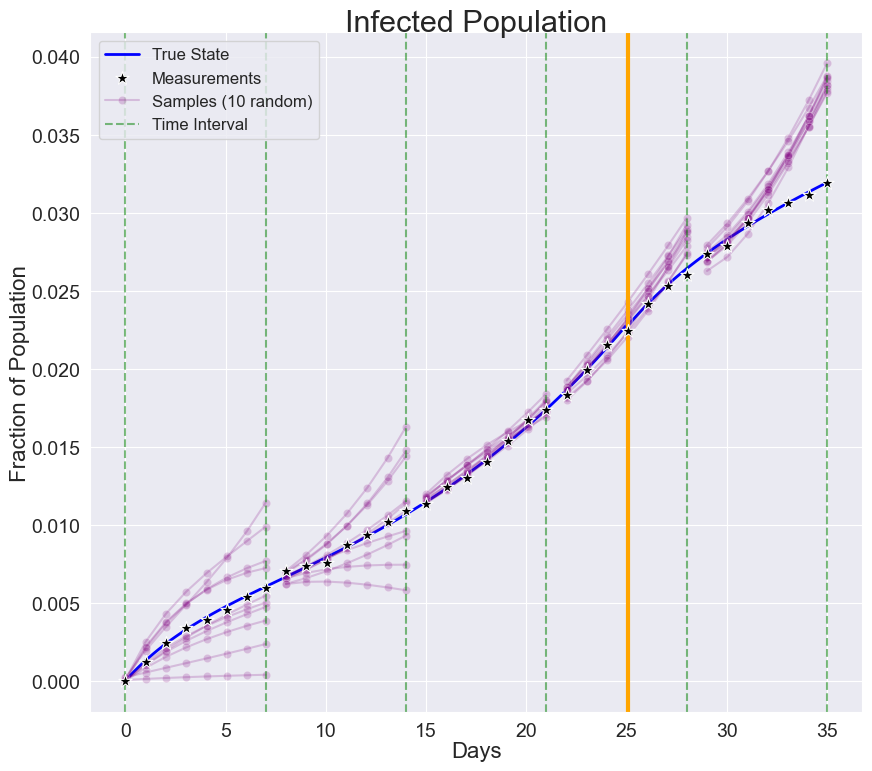

In [ ]:
sr.get_data(5*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_5 = get_l2_errs(res_5['search_results'], SEIRS_P1)
best.append(res_5['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

e_r         kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  \
0   5.847788e-16  11.215081   0.278968   0.168295   0.121212   0.004128   
0  1.644582e-124   9.866095   0.269825   0.161706   0.114015   0.002475   
0  2.732573e-126   9.201269   0.269825   0.161706   0.114015   0.002475   

   MUD_idx pca_components     pca_mask  i  index  predict_delta  \
0      454            [0]  range(0, 7)  0      0            1.0   
0      203         [0, 1]  range(0, 7)  0      1            1.0   
0      203      [0, 1, 2]  range(0, 7)  0      2            1.0   

   within_thresh  closest  max_kl  min_kl    l2_err   rel_err  
0          False    False   False   False  0.085506  0.319916  
0          False    False   False   False  0.072481  0.271186  
0          False    False   False   False  0.072481  0.271186

### Retrying but starting at original initial


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6647.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

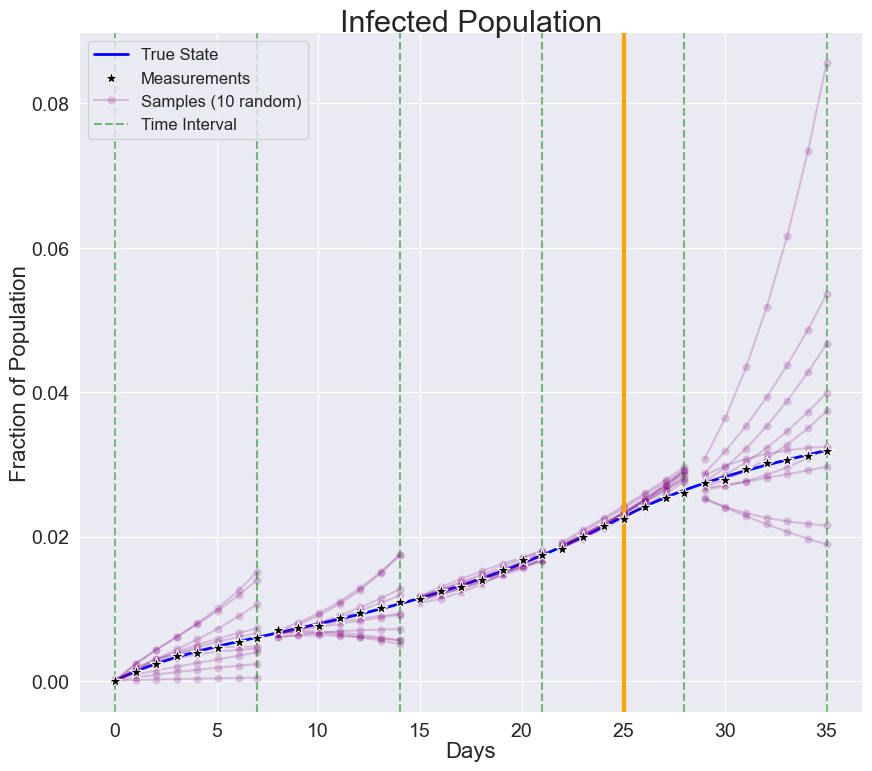

In [ ]:
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_5 = get_l2_errs(res_5['search_results'], SEIRS_P1)
best.append(res_5['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.201652  3.707657   0.070814   0.099673   0.041858   0.001024      602   
0  1.675196  6.133261   0.070814   0.099673   0.041858   0.001024      602   
0  1.281728  5.935910   0.070814   0.099673   0.041858   0.001024      602   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.201652           True   
0         [0, 1]  range(0, 7)  0      1       0.675196          False   
0      [0, 1, 2]  range(0, 7)  0      2       0.281728           True   

   closest  max_kl  min_kl   l2_err   rel_err  
0     True   False    True  0.15273  0.571433  
0    False   False   False  0.15273  0.571433  
0    False    True   False  0.15273  0.571433

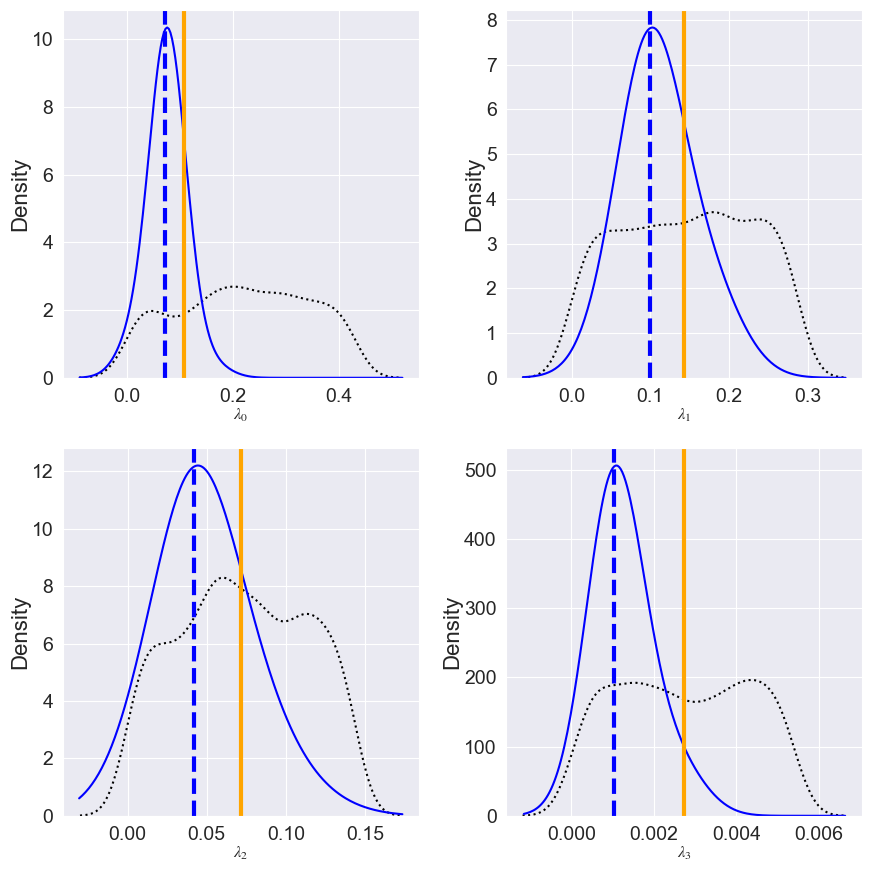

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P2])

# Full Algorithm

In [ ]:
def online_solve(self,
                 num_its=1,
                 max_nc=3,
                 data_chunk_size=7,
                 num_samples=100):
    """
    Online Solve
    """
    search_res = []
    bad_res = []
    scale = 1.0

    if len(self.probs) == 0:
        pi_in, samples = self.get_uniform_initial_samples(
            num_samples=num_samples,
            scale=1.0)
        it = 1
    else:
        pi_in = self.probs[-1].dists['pi_up']
        it = len(self.probs)

    max_its = it + num_its
    best_flag = np.empty((num_samples, 1), dtype=bool)
    while it < max_its:
        if it > len(self.data):
            # logger.info(f"Getting data for iteration {it}")
            self.get_data(it*data_chunk_size)

        self.forward_solve(samples)
        search_combs = self.get_search_combinations(
            max_nc=max_nc,
            data_chunk_size=data_chunk_size
        )
        disable_log()
        res = self.solve_search(
            search_combs,
            exp_thresh=0.1,
            best_method="max_kl",
            pi_in=pi_in
        )
        if res['best'] is None:
            avg_kl = np.mean(res['search_results']['kl'])
            logger.info(f'Suspected shift in params at {it}: KL Divergence: {avg_kl}')
            pi_in, samples = self.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
            bad_res.append((it, res))
        else:
            # logger.info(f"Best solution found:{res['best'].result}")
            self.probs.append(res['best'])
            best_flag[:] = False
            best_flag[res['best'].mud_arg] = True
            self.samples[-1]["best_flag"] = best_flag
            samples= self.probs[-1].sample_dist(num_samples=num_samples)
            pi_in = self.probs[-1].dists['pi_up']
            it += 1


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_l2_errs

importlib.reload(seirs)

n_weeks = 1
max_nc = 3
max_weeks = 2 # 1 year simulation
data_chunk_size = n_weeks*7
n_samples = 1000

best = []
sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=5*SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

it = 1
search_res = []
bad_res = []
scale = 1.0
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
best_flag = np.empty((n_samples, 1), dtype=bool)
while it < max_weeks:
    if it > len(sr.data):
        # logger.info(f"Getting data for iteration {it}")
        sr.get_data(data_chunk_size)

    sr.forward_solve(samples)
    search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
    disable_log()
    res = sr.solve_search(
        search_combs,
        exp_thresh=0.1,
        best_method="max_kl",
        pi_in=pi_in
    )
    if res['best'] is None:
        avg_kl = np.mean(res['search_results']['kl'])
        logger.info(f'Suspected shift in params at {it}: KL Divergence: {avg_kl}')
        pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
        bad_res.append((it, res))
    else:
        # logger.info(f"Best solution found:{res['best'].result}")
        best.append(res['best'])
        best_flag[:] = False
        best_flag[res['best'].mud_arg] = True
        sr.samples[-1]["best_flag"] = best_flag
        samples= best[-1].sample_dist(num_samples=n_samples)
        pi_in = best[-1].dists['pi_up']
        it += 1
        search_res.append(get_l2_errs(res['search_results'], SEIRS_P1))


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.2s (6456.
Solving for different combinations |████████████████████████████████████████| 3/


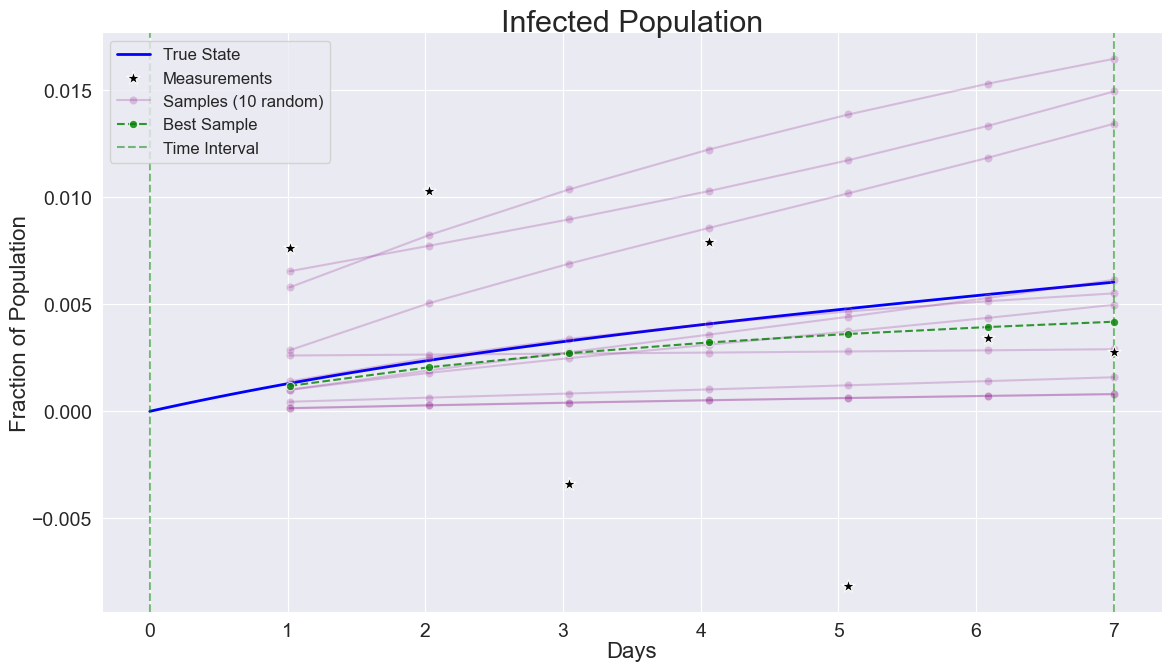

In [ ]:
ax = sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10)

(<AxesSubplot: xlabel='$\\lambda_0$', ylabel='Density'>,
 ['$\\pi^{in}_{\\lambda_0}$',
  '$\\pi^{up}_{\\lambda_0}$',
  '$\\lambda^{MUD}_0 = 0.2133$'])

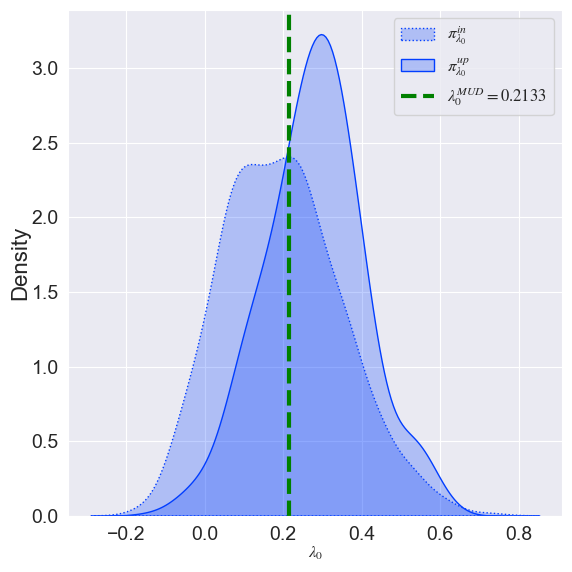

In [ ]:
best[3].plot_L(param_idx=0)

## First Shift - "Flattening the Curve"

Can we pick up shift in actual transmission rate as a result of a lockdown or other type of policy to reduce transmission rate?
This is the "flattening the curve" idea, where we want to reduce peak of the infected individuals during an outbreak.

IndexError: list index out of range

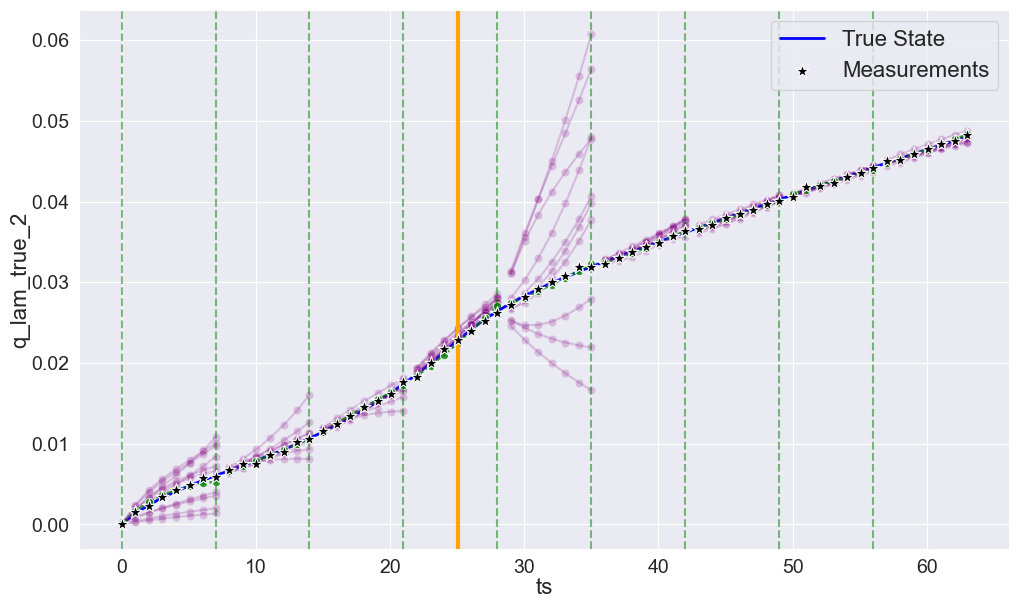

In [ ]:
ax = sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10, iterations=list(range(10))) 
ax.set_ylim(ax.get_ylim()[0], 0.1)

### Transmission Rate Shift

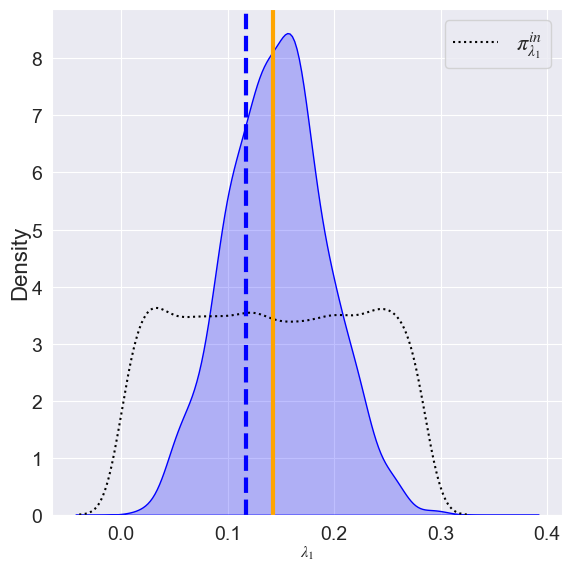

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

param_idx = 1
iterations = range(5)

# Plot Initial at start of iterations
_, labels = best[iterations[0]].plot_L(ax=ax,
                param_idx=param_idx,
                initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                update_kwargs=None,
                plot_legend=False,
                mud_kwargs=None,
                lam_true=None
)
ax.legend(labels)

# Plot updates in between

_, labels = best[iterations[-1]].plot_L(ax=ax,
                param_idx=param_idx,
                initial_kwargs=None,
                update_kwargs={"color": "blue", "linestyle": "-", "fill": True},
                plot_legend=False,
                mud_kwargs={'color': 'blue'},
                lam_true=[SEIRS_P1],
)

IndexError: list index out of range

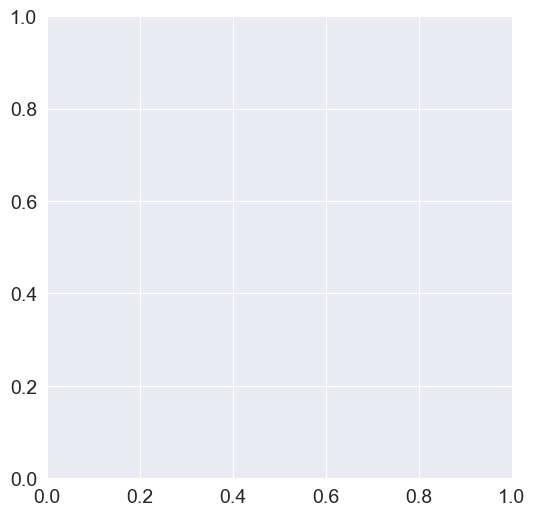

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

true_vals = np.array([SEIRS_P1, SEIRS_P2, SEIRS_P3])
iterations = range(0, 10)
param_idx = 0

# Plot initial at first iteration
best[iterations[0]].plot_L(ax=ax,
                param_idx=i,
                initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                update_kwargs=None,
                plot_legend=False,
                mud_kwargs=None,
                lam_true=None
)

for i  in iterations[1:-1]:
    best[i].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs=None,
                    update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                    plot_legend=False,
                    mud_kwargs=None,
                    lam_true=None
    )

# Plot update at final iteration
best[-1].plot_L(ax=ax,
                param_idx=i,
                initial_kwargs=None,
                update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                plot_legend=False,
                mud_kwargs={'color': 'blue'},
                lam_true=None,
)

## Second Shift - Virus Mutation

Virus mutation, leading to a straing that spreads and infects quicker.
Thus the rate of infection and rate of transmission go up. 
Difference in these two rates can be due to the fact that the virus for example

1. Can survive longer outside of a host, or can transmit through new means, hence increasing the transmission rate.
2. Infects a host faster once a host has been exposed to it. 

This leads to what is known as a "second wave" in the outbreak, as we saw with the COVID-19 mutations suchas omicron and delta.

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

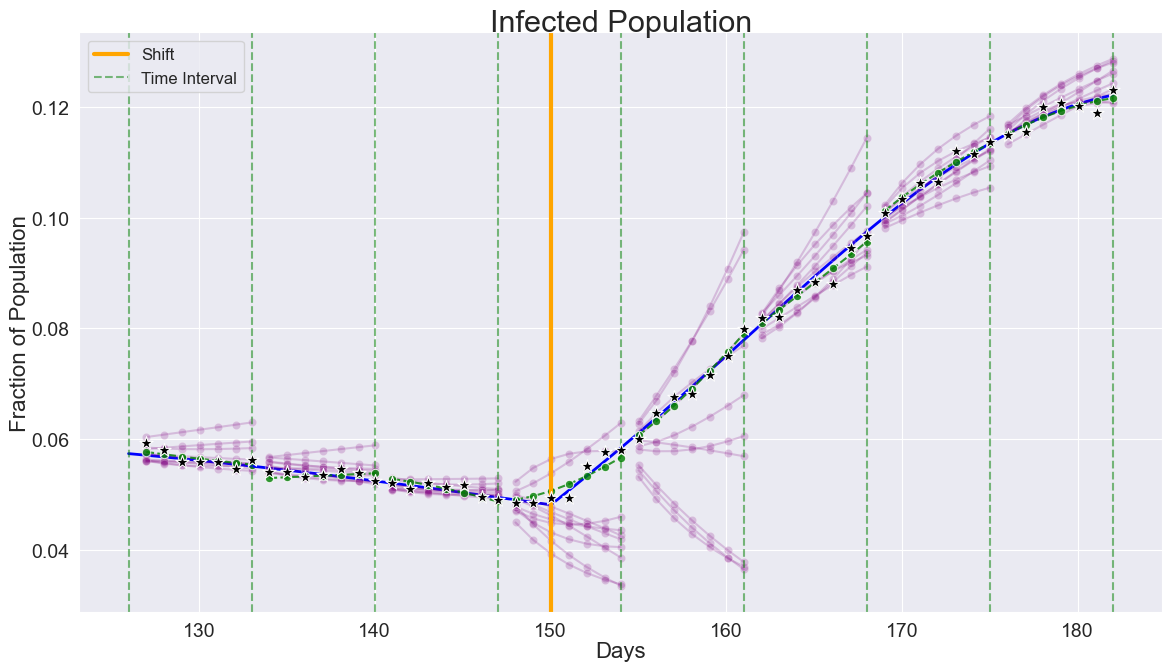

In [ ]:
sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10, iterations=list(range(18,26))) 

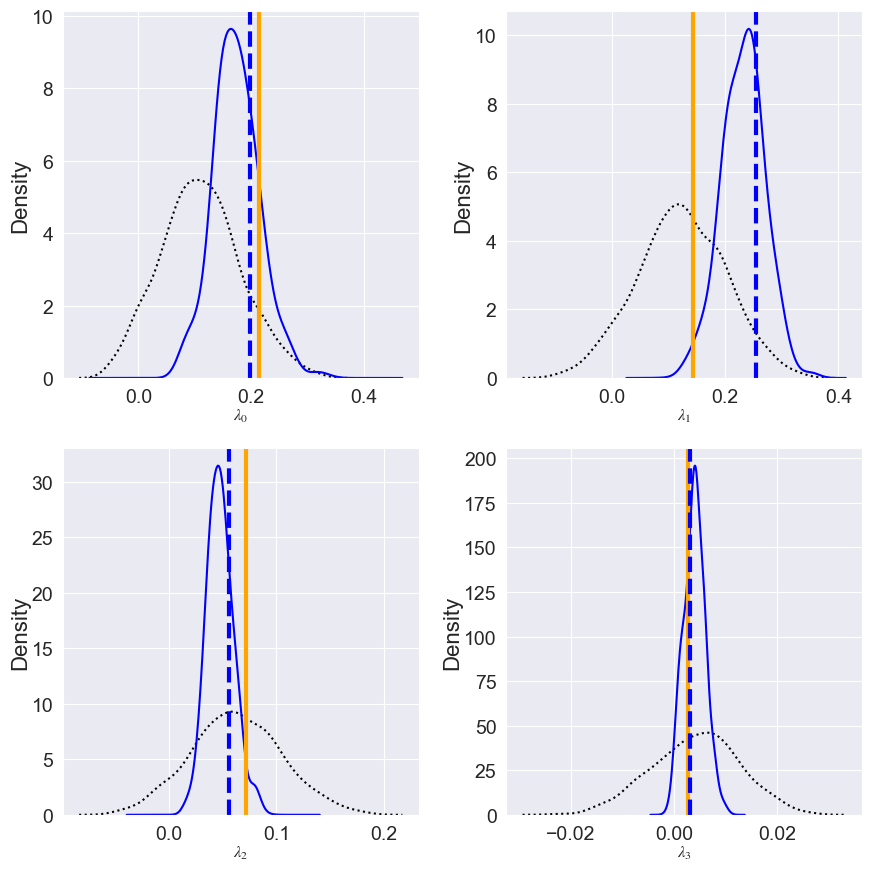

In [ ]:
plot_iterations(best[18:25], lam_true=[SEIRS_P1])

## Metrics over iterations - $\mathbb{E}(r)$ and $\mathrm{KL(\pi^\mathrm{up}_{i}|\pi^\mathrm{init})}$



In [ ]:
kl_vals = [x.result['kl'].values[0] for x in best]
e_r = [x.expected_ratio() for x in best]

In [ ]:
bad_kl = np.array([[7*x[0], x[1]['search_results']['kl'].mean()] for x in bad_res])
bad_e_r = np.array([[7*x[0], x[1]['search_results']['e_r'].mean()] for x in bad_res])

In [ ]:
bad_e_r

array([[3.50000000e+01, 3.62664017e-64]])

<AxesSubplot: >

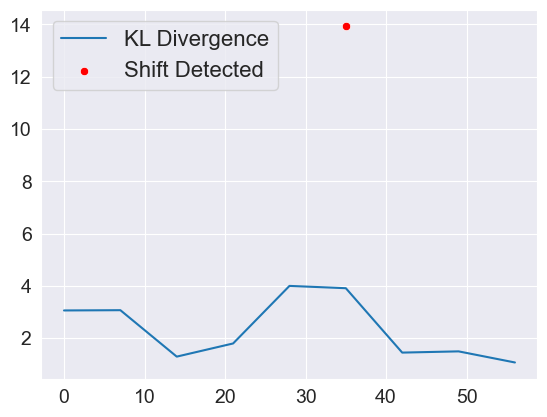

In [ ]:
import seaborn as sns
sns.lineplot(x=7*np.arange(len(kl_vals)), y=kl_vals, label='KL Divergence')
sns.scatterplot(x=bad_kl[:,0], y=bad_kl[:,1], label='Shift Detected', color='red')

<AxesSubplot: >

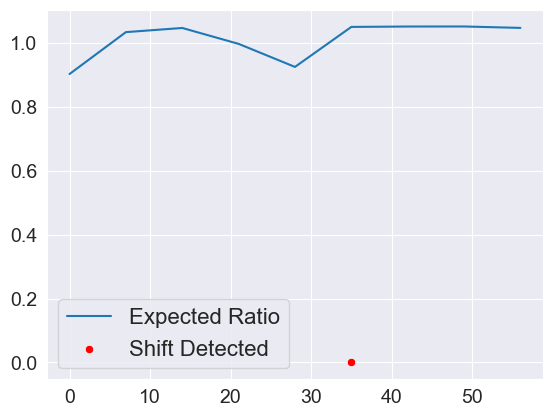

In [ ]:
import seaborn as sns
sns.lineplot(x=7*np.arange(len(e_r)), y=e_r, label='Expected Ratio')
sns.scatterplot(x=bad_e_r[:,0], y=bad_e_r[:,1], label='Shift Detected', color='red')

In [ ]:
from pydci.utils import get_df, put_df
import pandas as pd


for j in range(len(sr.data)):
    mud_est = get_df(sr.samples[j][sr.samples[j]['best_flag']], 'lam', size=sr.n_params)
    for i in range(sr.n_params):
        sr.data[j][f'lam_MUD_{i}'] = np.ones((len(sr.data[j]), 1)) * mud_est[0][i]
        sr.data[j][f'lam_{i}_l2'] = np.linalg.norm(sr.data[j][f'lam_true_{i}'] - sr.data[j][f'lam_MUD_{i}'])
        sr.data[j][f'lam_{i}_l2_rel'] = sr.data[j][f'lam_{i}_l2'] / np.linalg.norm(sr.data[j][f'lam_true_{i}'])

# Calculate relative l2 error between lam_true_{i} columns and lam_MUD_{i} columns
# for i in range(sr.n_params):
#     all_data[f'lam_{i}_l2'] = np.linalg.norm(all_data[f'lam_true_{i}'] - all_data[f'lam_MUD_{i}'])
#     all_data[f'lam_{i}_l2_rel'] = all_data[f'lam_{i}_l2'] / np.linalg.norm(all_data[f'lam_true_{i}'])
# 
# all_data
all_data = pd.concat(sr.data)


<AxesSubplot: xlabel='ts', ylabel='lam_3_l2_rel'>

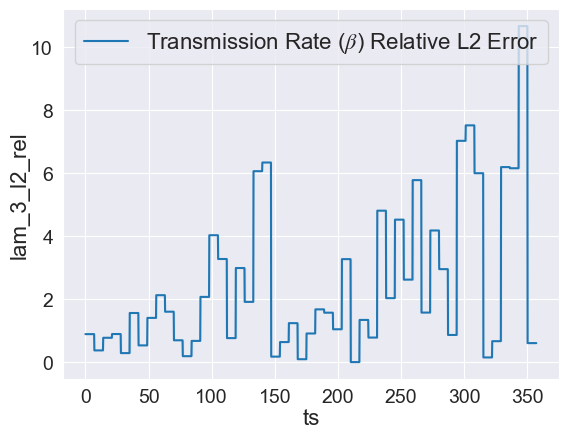

In [ ]:
import seaborn as sns
sns.lineplot(x='ts', y='lam_3_l2_rel', data=all_data, label='Transmission Rate ($\\beta$) Relative L2 Error')   

In [ ]:
# Nomr between to pandas collumns
sr.data[0]

ts  shift_idx  sample_flag  lam_true_0  q_lam_true_0  q_lam_true_1  \
0   0.000000          0         True    0.214286      0.990000      0.010000   
1   0.101449          0        False    0.214286      0.989998      0.009858   
2   0.202899          0        False    0.214286      0.989994      0.009720   
3   0.304348          0        False    0.214286      0.989986      0.009588   
4   0.405797          0        False    0.214286      0.989976      0.009461   
..       ...        ...          ...         ...           ...           ...   
65  6.594203          0        False    0.214286      0.985397      0.007271   
66  6.695652          0        False    0.214286      0.985273      0.007290   
67  6.797101          0        False    0.214286      0.985148      0.007310   
68  6.898551          0        False    0.214286      0.985021      0.007331   
69  7.000000          0         True    0.214286      0.984893      0.007354   

    q_lam_true_2  q_lam_true_3  q_lam_obs_0  lam_MUD_0  lam_MUD_1  lam_MUD_2  \
0       0.000000  0.000000e+00    -0.000659   0.131979   0.136436   0.084464   
1       0.000143  5.202547e-07          NaN   0.131979   0.136436   0.084464   
2       0.000284  2.067981e-06          NaN   0.131979   0.136436   0.084464   
3       0.000421  4.622827e-06          NaN   0.131979   0.136436   0.084464   
4       0.000556  8.163621e-06          NaN   0.131979   0.136436   0.084464   
..           ...           ...          ...        ...        ...        ...   
65      0.005785  1.546703e-03          NaN   0.131979   0.136436   0.084464   
66      0.005848  1.588417e-03          NaN   0.131979   0.136436   0.084464   
67      0.005912  1.630578e-03          NaN   0.131979   0.136436   0.084464   
68      0.005975  1.673185e-03          NaN   0.131979   0.136436   0.084464   
69      0.006037  1.716235e-03     0.004718   0.131979   0.136436   0.084464   

    lam_MUD_3  
0    0.002733  
1    0.002733  
2    0.002733  
3    0.002733  
4    0.002733  
..        ...  
65   0.002733  
66   0.002733  
67   0.002733  
68   0.002733  
69   0.002733  

[70 rows x 13 columns]

In [ ]:
## Per Parameter, l2 error over each iteration

def process_iterations(iterations=None):
    """
    """
    iterations = iterations if iterations is not None else range(len(self.data))

    for it in iterations:
        data = self.data[]


# Using All States



In [ ]:
import numpy as np
from pydci.examples import seirs
import importlib

importlib.reload(seirs)

sr = seirs.SEIRSModel()

Solving model sample set: |⚠︎                   | (!) 0/2 [0%] in 0.1s (0.00/s)  


TypeError: 'rv_continuous_frozen' object is not iterable

In [ ]:
import pandas as pd
from numpy.linalg import LinAlgError
import seaborn as sns
from pydci.log import enable_log, disable_log
import math 
from alive_progress import alive_bar
from pydci import PCAMUDProblem
from pydci.log import logger
import numpy as np
import pandas as pd

def solve_search(
    self,
    prob_args, 
    search_list,
    def_args = None,
    exp_thresh: float = 0.5,
    best_method: str = "closest",
):
    """
    Search through different iterations of solvign the PCA problem

    Thea idea of this method is, given a chunk of data, and a list of
    different iterative solve arguments, solve them and determine
    the "best" solution

    # TODO: Move this inside of Model class: self -> self

    Parameters
    ----------
    """

    am = ["closest", "min_kl", "max_kl"]
    if best_method not in am:
        msg = f"Unrecognized best method {best_method}. Allowed: {am}"
        raise ValueError(msg)
    if exp_thresh <= 0:
        msg = f"Expected ratio thresh must be a float > 0: {exp_thresh}"
        raise ValueError(msg)

    all_search_results = []
    all_results = []
    with alive_bar(
        len(search_list),
        title="Solving for different combinations",
        force_tty=True,
        receipt=True,
        length=40,
    ) as bar:
        for idx, args in enumerate(search_list):
            args.update(def_args if def_args is not None else {})

            # Solve -> Saves states in state dictionary
            prob = PCAMUDProblem(prob_args['samples'],
                                 prob_args['data'],
                                 self.measurement_noise,
                                 pi_in=prob_args['pi_in'])
                                 
            try:
                prob.solve_it(**args, state_extra={"search_index": idx})
            except ZeroDivisionError or KDEError as e:
                logger.error(f"Failed: Ill-posed problem: {e}")
                continue 
            except RuntimeError as r:
                if "No solution found within exp_thresh" in str(r):
                    logger.error(f"Failed: No solution in exp_thresh: {r}")
                    continue
                else:
                    raise r
            except LinAlgError as e:
                logger.exception(str(e))
                return prob
            else:
                # ! What state do we need to whipe here to ensure back to original conditions of search on next iteration?
                # Store results per each iteration and final result
                # This will be erased the next iteration if we don't store it
                all_search_results.append(prob.it_results.copy())
                all_search_results[-1]["index"] = idx
                all_results.append(prob.result.copy())
                all_results[-1]["index"] = idx

            bar()

    # Parse DataFrame with results of mud estimations for each ts choice
    res_df = pd.concat(all_results)
    res_df["predict_delta"] = np.abs(res_df["e_r"] - 1.0)
    res_df["within_thresh"] = res_df["predict_delta"] <= exp_thresh
    res_df["closest"] = np.logical_and(
        res_df["predict_delta"]
        <= res_df[res_df["within_thresh"]]["predict_delta"].min(),
        res_df["within_thresh"],
    )
    res_df["max_kl"] = np.logical_and(
        res_df["kl"] >= res_df[res_df["within_thresh"]]["kl"].max(),
        res_df["within_thresh"],
    )
    res_df["min_kl"] = np.logical_and(
        res_df["kl"] <= res_df[res_df["within_thresh"]]["kl"].min(),
        res_df["within_thresh"],
    )

    # Set to best
    search_results = res_df
    all_search_results = pd.concat(all_search_results) # Has internal iterations for each try
    result = res_df[res_df[best_method]]

    if len(result) == 0:
        raise RuntimeError(f'No solution found within exp_thresh')
    else:
        # Re-solve Using Best
        best = PCAMUDProblem(prob_args['samples'],
                             prob_args['data'],
                             self.measurement_noise,
                             pi_in=prob_args['pi_in'])
        try:
            logger.info(f"Resolving with best result: {result['index'].values[0]}")
            best.solve_it(**search_list[result['index'].values[0]])
        except LinAlgError as e:
            return best
    
    return {'best': best, 'search_results': search_results, 'all_search_results': all_search_results}


def get_search_combinations(self,
                            data_idx=-1,
                            exp_thresh=1e10,
                            max_nc=5,
                            ):
    """
    """
    if len(self.data) == 0 or data_idx > len(self.data):
        raise ValueError(f"Invalid data_idx: {data_idx}. Data length: {len(self.data)}")
    df = self.data[data_idx]
    sampled_data = df[df['sample_flag']]
    n_data = len(sampled_data) *  self.n_states
    data_chunk_size = self.n_params if self.n_params <= n_data else n_data

    def order_of_magnitude(n):
        return int(math.log10(n)) + 1

    # * Restrict max number of principle components by number of sensors available
    # * Or else KDEs will fail on higher dimensional data.
    max_nc = min(order_of_magnitude(len(self.samples[data_idx])), max_nc)

    # * PCA component variations -> Dependent on sample size (and # of data points if <= n_params)
    # First choose # of principle components to use. 
    # Start with just doing all possible:  1->data_chunk_size.
    # TODO: Future -> Use sample size to determine how many components to use (dimenionalsity of problem)
    # * Data Mask -> What percent of total data to use
    # * Increasing chunks of data_chunk_size.
    search_list = [
        {
            'exp_thresh': exp_thresh,
            'pca_components': [list(range(i + 1))],
            'pca_mask': range(j),
            'pca_splits': k,
        }
        for i in range(min(max_nc, data_chunk_size))
        for j in range(data_chunk_size, n_data, data_chunk_size)
        for k in range(1, (n_data + 1)%data_chunk_size + 1)
        if j/(k*data_chunk_size) >= 1.0 
    ]

    return search_list

enable_log()

[07/18/23 08:44:22] INFO     Logger initialized                                                           ]8;id=436149;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=674406;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

In [ ]:
# Initialize Problem
num_samples = 100
sr = seirs.SEIRSModel()

# Get initial samples
pi_in, samples = sr.get_uniform_initial_samples(num_samples=num_samples, scale=0.5)

res = {'res': [], 'samples': []}
time_step = 30
max_its = 5

i = 0
t = 0
best_flag = np.empty((num_samples, 1), dtype=bool)
while i < max_its:
    t += time_step
    f_res = sr.forward_solve(t, samples=samples)
    search_combs = get_search_combinations(
        sr, exp_thresh=1e10)

    # disable_log()
    enable_log(level='DEBUG', file='test.log')
    prob_args = {'samples': f_res['samples'],
                'data': f_res['data'],
                'pi_in': pi_in}
    search_res = solve_search(sr, prob_args, search_combs, exp_thresh=1e10, best_method='closest')
    res['res'].append(search_res)
    res['samples'].append(samples)
    best_flag[:] = False
    best_flag[search_res['best'].mud_arg] = True
    sr.samples[i]["best_flag"] = best_flag
    samples = search_res['best'].sample_dist(num_samples=num_samples, dist='pi_up')
    i += 1

Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (1334.85
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (4612.45
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (4543.64
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (3954.36
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (866.62/
Solving for different combinations |████████████████████████████████████████| 15


In [ ]:
pd.concat([x['best'].result for x in res['res']])

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.999101  0.863687   0.236150   0.148632   0.068547   0.002942       78   
0  0.993275  0.110840   0.195507   0.117860   0.091021   0.003761       28   
0  1.001651  2.591088   0.187960   0.242769   0.060708   0.004376       51   
0  1.016326  1.870318   0.209609   0.257509   0.073005   0.004792       67   
0  1.002574  0.010458   0.226851   0.262391   0.078109   0.005217       51   

  pca_components      pca_mask  i  
0            [0]   range(0, 8)  0  
0            [0]   range(0, 4)  0  
0            [0]  range(0, 16)  0  
0            [0]  range(0, 16)  0  
0            [0]   range(0, 4)  0

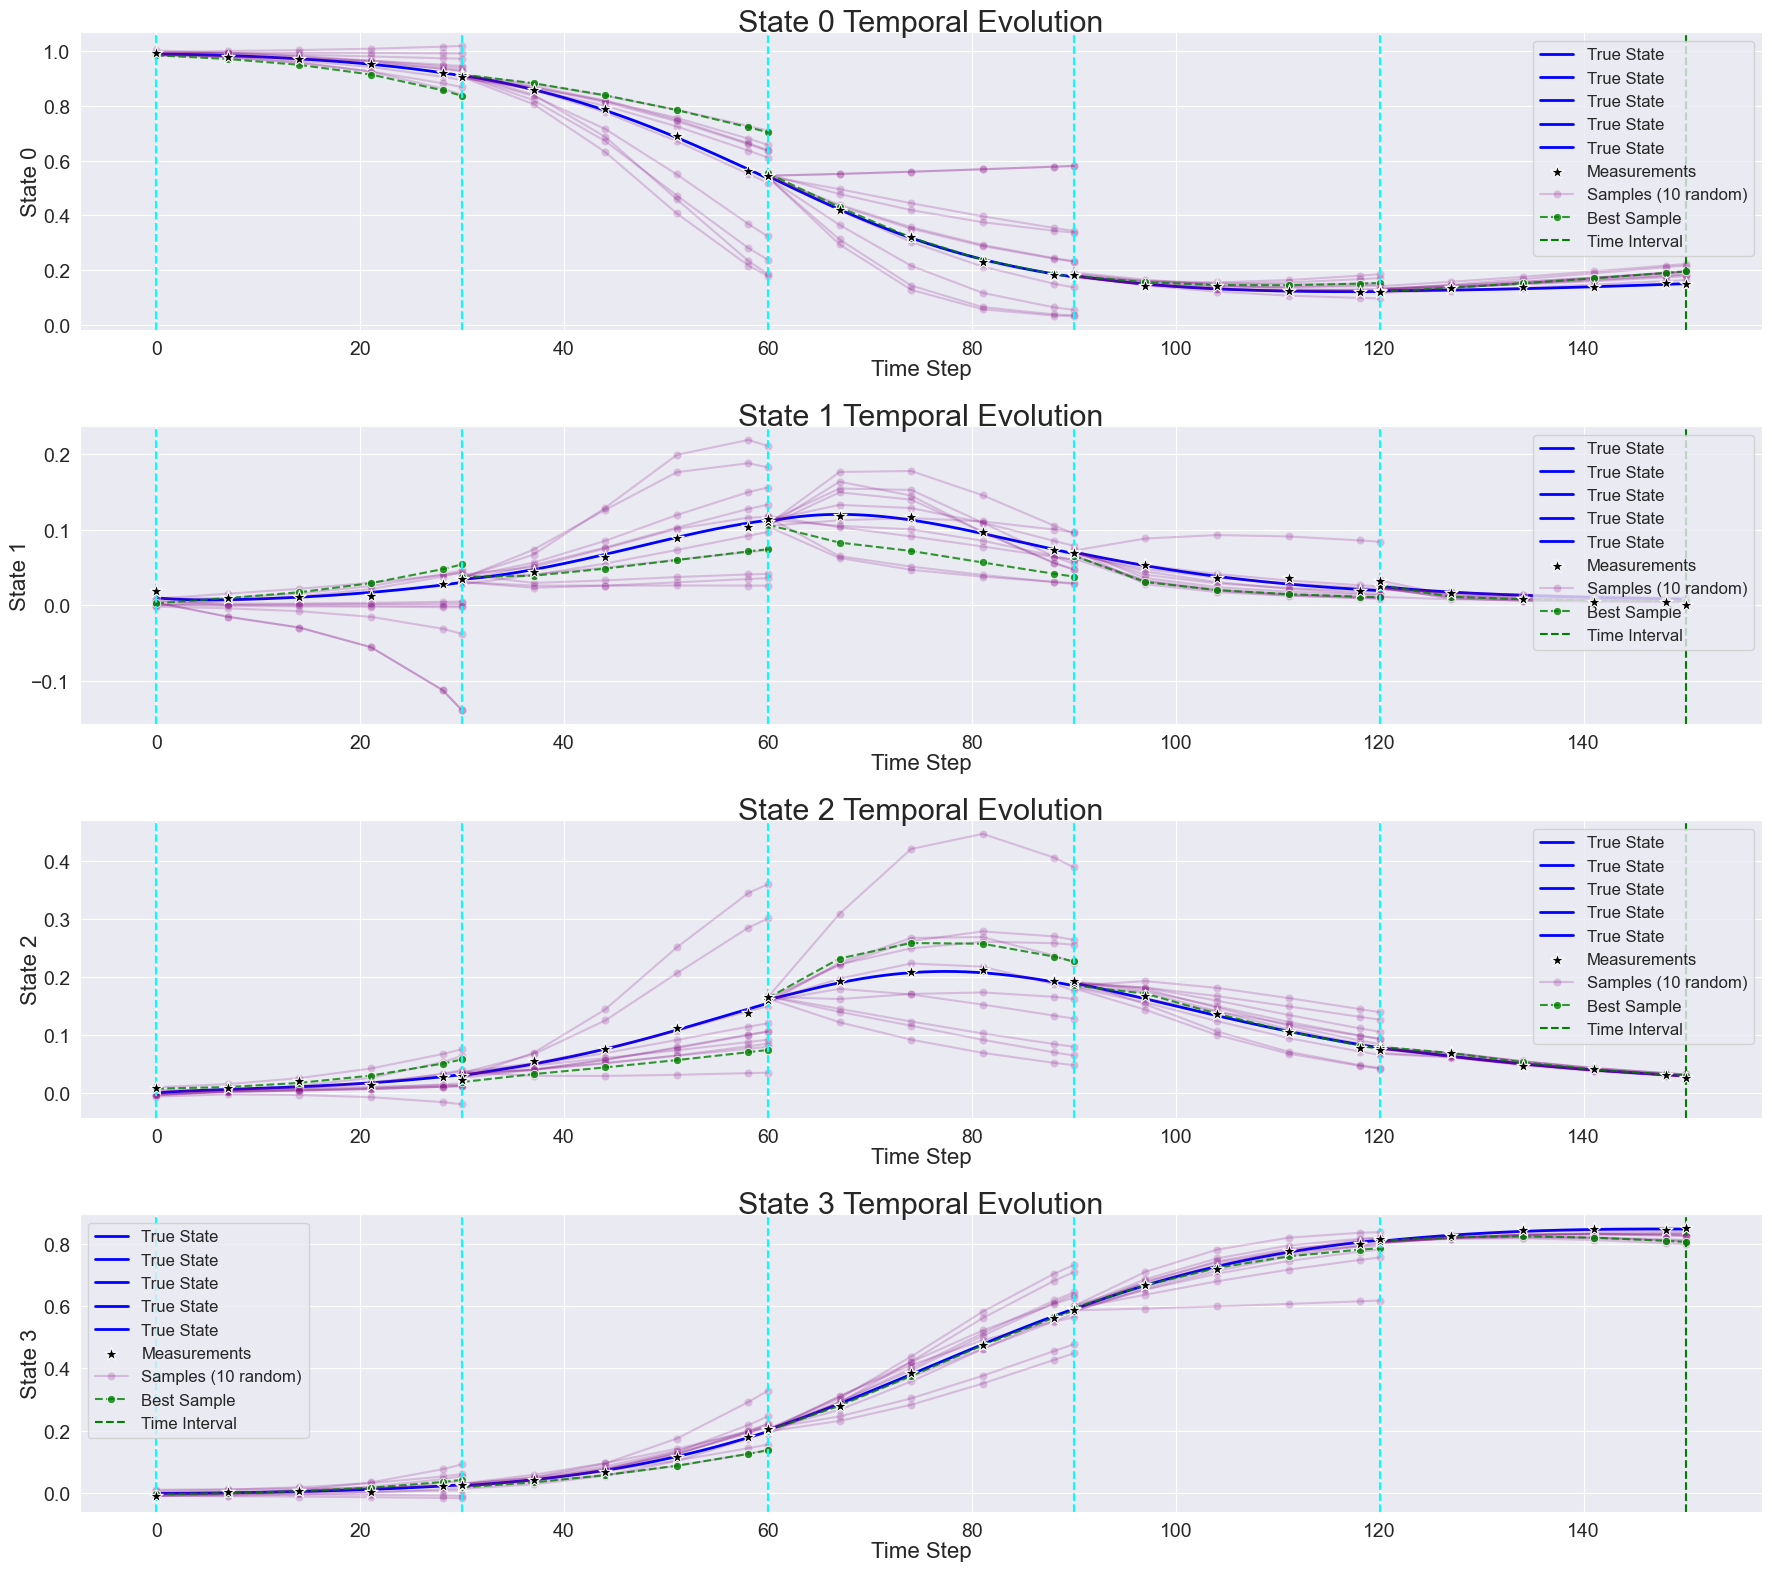

In [ ]:
sr.plot_states()